In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os

In [2]:
import keras_tuner as kt
from keras_tuner import RandomSearch

In [3]:
from sklearn.metrics import mean_absolute_error,mean_squared_error,mean_absolute_percentage_error

In [4]:
import relative_accuracy as ra
from statistics import mean, stdev

In [5]:
# Load all Inputs and Output Data

# 5 mins (1 step ahead)
Deep_train_5   = np.load("Deep_train_5.npz")['x'] 
Output_train_5 = np.load("Deep_train_5.npz")['y']

Deep_test_5   = np.load("Deep_test_5.npz")['x'] 
Output_test_5 = np.load("Deep_test_5.npz")['y'] 

# 15 mins (3 steps ahead)
Deep_train_15   = np.load("Deep_train_15.npz")['x'] 
Output_train_15 = np.load("Deep_train_15.npz")['y']

Deep_test_15   = np.load("Deep_test_15.npz")['x'] 
Output_test_15 = np.load("Deep_test_15.npz")['y']

# 30 mins (6 steps ahead)
Deep_train_30   = np.load("Deep_train_30.npz")['x'] 
Output_train_30 = np.load("Deep_train_30.npz")['y']

Deep_test_30   = np.load("Deep_test_30.npz")['x'] 
Output_test_30 = np.load("Deep_test_30.npz")['y']

# 60 mins (12 steps ahead)
Deep_train_60   = np.load("Deep_train_60.npz")['x'] 
Output_train_60 = np.load("Deep_train_60.npz")['y']

Deep_test_60   = np.load("Deep_test_60.npz")['x'] 
Output_test_60 = np.load("Deep_test_60.npz")['y']

In [6]:
# Wide Data
Xtrain = joblib.load("002weeks_train.save") 
Xtest = joblib.load("002weeks_test.save") 

In [7]:
# 5 mins
# Delete first 15 samples
Wide_train_5 = np.delete(Xtrain, np.s_[0:15], 0)
Wide_test_5 = np.delete(Xtest, np.s_[0:15], 0)

In [8]:
# 15 mins
# Delete first 17 samples
Wide_train_15 = np.delete(Xtrain, np.s_[0:17], 0)
Wide_test_15 = np.delete(Xtest, np.s_[0:17], 0)

In [9]:
# 30 mins
# Delete first 20 samples
Wide_train_30 = np.delete(Xtrain, np.s_[0:20], 0)
Wide_test_30 = np.delete(Xtest, np.s_[0:20], 0)

In [10]:
# 60 mins
# Delete first 27 samples
Wide_train_60 = np.delete(Xtrain, np.s_[0:26], 0)
Wide_test_60 = np.delete(Xtest, np.s_[0:26], 0)

In [11]:
scaler_filename = "scaler.save"
scaler = joblib.load(scaler_filename) 

C:\Users\esugom\AppData\Roaming\Python\Python38\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator MinMaxScaler from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [12]:
Test      = pd.read_csv('01test_scaled.csv', index_col=None, parse_dates=[0])

# Reshape Samples

The first step is to split the input sequences into subsequences that can be processed by the CNN model. Here, each spatio-temporal sample can be split into three sub-samples, each with five time steps. The CNN can interpret each subsequence of five time steps and provide a time series of interpretations of the subsequences to the LSTM model to process as input.

In [13]:
# reshape from [samples, timesteps] into [samples, subsequences, timesteps, features]
n_features = 6                # No of loop detectors
n_seq = 3                     # Subsequences
n_steps = 5                   # time-step per subsequence
val_percent = 0.07567         # 2 weeks
batch_size = 32

#### 5 mins

In [14]:
# Train
# reshape from [samples, timesteps] into [samples, subsequences, timesteps, features]
Xt5 = Deep_train_5.reshape((Deep_train_5.shape[0], n_seq, n_steps, n_features))
yt5 = Output_train_5

In [15]:
# Test
# reshape from [samples, timesteps] into [samples, subsequences, timesteps, features]
Xv5 = Deep_test_5.reshape((Deep_test_5.shape[0], n_seq, n_steps, n_features))
yv5 = Output_test_5

#### 15 mins

In [16]:
# Train
# reshape from [samples, timesteps] into [samples, subsequences, timesteps, features]
Xt15 = Deep_train_15.reshape((Deep_train_15.shape[0], n_seq, n_steps, n_features))
yt15 = Output_train_15

In [17]:
# Test
# reshape from [samples, timesteps] into [samples, subsequences, timesteps, features]
Xv15 = Deep_test_15.reshape((Deep_test_15.shape[0], n_seq, n_steps, n_features))
yv15 = Output_test_15

#### 30 mins

In [18]:
# Train
# reshape from [samples, timesteps] into [samples, subsequences, timesteps, features]
Xt30 = Deep_train_30.reshape((Deep_train_30.shape[0], n_seq, n_steps, n_features))
yt30 = Output_train_30

In [19]:
# Test
# reshape from [samples, timesteps] into [samples, subsequences, timesteps, features]
Xv30 = Deep_test_30.reshape((Deep_test_30.shape[0], n_seq, n_steps, n_features))
yv30 = Output_test_30

#### 60 mins

In [20]:
# Train
# reshape from [samples, timesteps] into [samples, subsequences, timesteps, features]
Xt60 = Deep_train_60.reshape((Deep_train_60.shape[0], n_seq, n_steps, n_features))
yt60 = Output_train_60

In [21]:
# Test
# reshape from [samples, timesteps] into [samples, subsequences, timesteps, features]
Xv60 = Deep_test_60.reshape((Deep_test_60.shape[0], n_seq, n_steps, n_features))
yv60 = Output_test_60

### Reshaping the Data for Conv2D layer

For Conv2D, there is a need to add one more dimension to show we're dealing with 1 channel (since technically the images are in black and white, only showing values from 0-max flow on a single channel).

Conv1D - strides in 1 dimension
Conv2D - strides in 2 dimensions

In [22]:
# define no_of_channels
n_channels = 1

In [23]:
# Train data
Xt5  =  Xt5.reshape(Xt5.shape[0], n_seq, n_steps, n_features, n_channels)
Xt15 =  Xt15.reshape(Xt15.shape[0], n_seq, n_steps, n_features, n_channels)
Xt30 =  Xt30.reshape(Xt30.shape[0], n_seq, n_steps, n_features, n_channels)
Xt60 =  Xt60.reshape(Xt60.shape[0], n_seq, n_steps, n_features, n_channels)

# Validation data
Xv5  =  Xv5.reshape(Xv5.shape[0], n_seq, n_steps, n_features, n_channels)
Xv15 =  Xv15.reshape(Xv15.shape[0], n_seq, n_steps, n_features, n_channels)
Xv30 =  Xv30.reshape(Xv30.shape[0], n_seq, n_steps, n_features, n_channels)
Xv60 =  Xv60.reshape(Xv60.shape[0], n_seq, n_steps, n_features, n_channels)

In [24]:
Wt5  = Wide_train_5
Wt15 = Wide_train_15
Wt30 = Wide_train_30
Wt60 = Wide_train_60

Wv5  = Wide_test_5
Wv15 = Wide_test_15
Wv30 = Wide_test_30
Wv60 = Wide_test_60

# CNN-LSTM model

In [25]:
from tensorflow import keras

# Early Stopping
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss',patience=5)

In [26]:
stop = keras.callbacks.EarlyStopping(
    monitor = 'val_loss', 
    patience = 5,
    restore_best_weights = True)

In [27]:
Wide_train_5.shape

(49233, 14)

# 5 mins ahead

In [28]:
def build_model_5(hp):
    # Inputs
    channel_Wide = keras.layers.Input(shape=Wide_train_5.shape[1:], name="WideInput")
    channel_Deep = keras.layers.Input(shape=(None, n_steps, n_features, n_channels), name="DeepInput")
    
    # Wide Model
    Wide_5 = keras.layers.Dense(
        units=hp.Int("units_NN", min_value=10, max_value=100, step=1), activation="relu"
    )(channel_Wide)
    
    # Deep Model
    # CNN 
    CNN_5 = keras.layers.TimeDistributed(
        keras.layers.Conv2D(filters=hp.Int("filters", min_value=32, max_value=512, step=32),
                            kernel_size=hp.Choice("kernel_size", [2, 3]), activation='relu'))(channel_Deep)
    flatten_5 = keras.layers.TimeDistributed(keras.layers.Flatten())(CNN_5)
    # LSTM          
    LSTM_5 = keras.layers.LSTM(units=hp.Int("units_LSTM", min_value=1, max_value=100, step=1), 
                                activation='relu')(flatten_5)
    
    # Concatenation 
    concat = keras.layers.concatenate([Wide_5, LSTM_5])
    
    # Output
    output = keras.layers.Dense(1, name= "output")(concat)
    
    # Model
    model_5 = keras.Model(inputs=[channel_Wide,channel_Deep], outputs=[output])

    # Compile
    model_5.compile(optimizer=keras.optimizers.Adam(hp.Choice("learning_rate", [1e-2, 1e-3, 1e-4])), 
        loss='mse',metrics=['MeanAbsoluteError','RootMeanSquaredError','MeanAbsolutePercentageError'])
                    
    return model_5

In [29]:
tuner5 = RandomSearch(
    build_model_5,
    objective="val_loss",
    max_trials=60,
    executions_per_trial=5,
    overwrite=False,
    directory=os.path.normpath('C:/RunsOak'),
    project_name="7d-CNN-LSTM-5",
)

INFO:tensorflow:Reloading Oracle from existing project C:\RunsOak\7d-CNN-LSTM-5\oracle.json
INFO:tensorflow:Reloading Tuner from C:\RunsOak\7d-CNN-LSTM-5\tuner0.json


In [30]:
tuner5.search_space_summary()

Search space summary
Default search space size: 5
units_NN (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 100, 'step': 1, 'sampling': None}
filters (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
kernel_size (Choice)
{'default': 2, 'conditions': [], 'values': [2, 3], 'ordered': True}
units_LSTM (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 100, 'step': 1, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [31]:
tuner5.search((Wt5,Xt5), yt5, epochs=200,
           validation_split = val_percent,
           callbacks = [early_stop],
           verbose=2)

INFO:tensorflow:Oracle triggered exit


In [32]:
tuner5.results_summary(1)

Results summary
Results in C:\RunsOak\7d-CNN-LSTM-5
Showing 1 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
units_NN: 78
filters: 192
kernel_size: 3
units_LSTM: 11
learning_rate: 0.0001
Score: 0.0017112368252128363


### Best Model

In [33]:
best_hp5 = tuner5.get_best_hyperparameters()[0]
model5 = tuner5.hypermodel.build(best_hp5)

In [34]:
scaler_filename = "Best_HP/7d-ConvLSTM-5"
joblib.dump(best_hp5, scaler_filename) 

['Best_HP/7d-ConvLSTM-5']

In [35]:
model5.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
DeepInput (InputLayer)          [(None, None, 5, 6,  0                                            
__________________________________________________________________________________________________
time_distributed (TimeDistribut (None, None, 3, 4, 1 1920        DeepInput[0][0]                  
__________________________________________________________________________________________________
WideInput (InputLayer)          [(None, 14)]         0                                            
__________________________________________________________________________________________________
time_distributed_1 (TimeDistrib (None, None, 2304)   0           time_distributed[0][0]           
_______________________________________________________________________________________

In [36]:
#model5.fit((Wt5,Xt5), yt5, 
#           epochs = 100, 
#           verbose = 0)

In [37]:
#model5.save("my_dir/7d-CNN-LSTM-5")

In [38]:
#metrics5 = pd.DataFrame(model5.history.history)

In [39]:
#metrics5[['loss']].plot()

In [40]:
MSE5  = []
MAE5  = []
RMSE5 = []
MAPE5 = []

for i in range(100):
    print(f"run: {i+1}")
    model5.fit((Wt5,Xt5), yt5, 
           epochs = 200, validation_split = val_percent,
           callbacks = [stop],
           verbose = 1)

    test_predictions5 = model5.predict((Wv5,Xv5))

    yv5 = scaler.inverse_transform(Test.drop('Timestamp', axis = 1))
    yv5 = yv5[15:,3]

    df = Test.drop(Test.head(15).index)
    df.reset_index(inplace = True)
    df = df.drop(columns=['index','Timestamp'])
    df['f4'] = pd.Series(test_predictions5.flatten())

    test_predictions5 = scaler.inverse_transform(df)

    test_predictions5 = test_predictions5[:,3]

    MSE5.append(mean_squared_error(yv5,test_predictions5))

    MAE5.append(mean_absolute_error(yv5,test_predictions5))

    RMSE5.append(np.sqrt(mean_squared_error(yv5,test_predictions5)))

    MAPE5.append(mean_absolute_percentage_error(yv5,test_predictions5)*100)
    
    
    current_mse = mean_squared_error(yv5,test_predictions5)
    if all(i > current_mse for i in MSE5):
        model5.save("my_dir/7d-CNN-LSTM-5")

eval5 = [mean(MSE5), mean(MAE5), mean(RMSE5), mean(MAPE5)]
std5 = [stdev(MSE5), stdev(MAE5), stdev(RMSE5), stdev(MAPE5)]
print(eval5)

run: 1
Epoch 1/200
1423/1423 [==============================] - 11s 8ms/step - loss: 0.0053 - mean_absolute_error: 0.0437 - root_mean_squared_error: 0.0727 - mean_absolute_percentage_error: 1199.7581 - val_loss: 0.0019 - val_mean_absolute_error: 0.0327 - val_root_mean_squared_error: 0.0436 - val_mean_absolute_percentage_error: 11.0485
Epoch 2/200
1423/1423 [==============================] - 11s 7ms/step - loss: 0.0019 - mean_absolute_error: 0.0326 - root_mean_squared_error: 0.0437 - mean_absolute_percentage_error: 1113.8550 - val_loss: 0.0019 - val_mean_absolute_error: 0.0324 - val_root_mean_squared_error: 0.0430 - val_mean_absolute_percentage_error: 11.4990
Epoch 3/200
1423/1423 [==============================] - 10s 7ms/step - loss: 0.0018 - mean_absolute_error: 0.0317 - root_mean_squared_error: 0.0426 - mean_absolute_percentage_error: 1043.3571 - val_loss: 0.0018 - val_mean_absolute_error: 0.0317 - val_root_mean_squared_error: 0.0420 - val_mean_absolute_percentage_error: 11.3174
Epo

Epoch 6/200
1423/1423 [==============================] - 9s 6ms/step - loss: 0.0017 - mean_absolute_error: 0.0310 - root_mean_squared_error: 0.0417 - mean_absolute_percentage_error: 699.8689 - val_loss: 0.0017 - val_mean_absolute_error: 0.0310 - val_root_mean_squared_error: 0.0414 - val_mean_absolute_percentage_error: 10.7478
Epoch 7/200
1423/1423 [==============================] - 10s 7ms/step - loss: 0.0017 - mean_absolute_error: 0.0309 - root_mean_squared_error: 0.0416 - mean_absolute_percentage_error: 620.4282 - val_loss: 0.0017 - val_mean_absolute_error: 0.0310 - val_root_mean_squared_error: 0.0415 - val_mean_absolute_percentage_error: 10.4257
Epoch 8/200
1423/1423 [==============================] - 9s 7ms/step - loss: 0.0017 - mean_absolute_error: 0.0309 - root_mean_squared_error: 0.0416 - mean_absolute_percentage_error: 656.7103 - val_loss: 0.0017 - val_mean_absolute_error: 0.0310 - val_root_mean_squared_error: 0.0414 - val_mean_absolute_percentage_error: 10.8389
Epoch 9/200
142

Epoch 11/200
1423/1423 [==============================] - 9s 7ms/step - loss: 0.0017 - mean_absolute_error: 0.0307 - root_mean_squared_error: 0.0414 - mean_absolute_percentage_error: 610.4781 - val_loss: 0.0019 - val_mean_absolute_error: 0.0322 - val_root_mean_squared_error: 0.0433 - val_mean_absolute_percentage_error: 10.5345
Epoch 12/200
1423/1423 [==============================] - 9s 6ms/step - loss: 0.0017 - mean_absolute_error: 0.0307 - root_mean_squared_error: 0.0414 - mean_absolute_percentage_error: 584.3422 - val_loss: 0.0017 - val_mean_absolute_error: 0.0312 - val_root_mean_squared_error: 0.0417 - val_mean_absolute_percentage_error: 10.4949
Epoch 13/200
1423/1423 [==============================] - 9s 7ms/step - loss: 0.0017 - mean_absolute_error: 0.0307 - root_mean_squared_error: 0.0414 - mean_absolute_percentage_error: 610.7077 - val_loss: 0.0020 - val_mean_absolute_error: 0.0332 - val_root_mean_squared_error: 0.0447 - val_mean_absolute_percentage_error: 10.6632
Epoch 14/200


Epoch 5/200
1423/1423 [==============================] - 9s 6ms/step - loss: 0.0017 - mean_absolute_error: 0.0306 - root_mean_squared_error: 0.0412 - mean_absolute_percentage_error: 625.3307 - val_loss: 0.0017 - val_mean_absolute_error: 0.0310 - val_root_mean_squared_error: 0.0414 - val_mean_absolute_percentage_error: 10.9074
Epoch 6/200
1423/1423 [==============================] - 10s 7ms/step - loss: 0.0017 - mean_absolute_error: 0.0306 - root_mean_squared_error: 0.0412 - mean_absolute_percentage_error: 763.9531 - val_loss: 0.0017 - val_mean_absolute_error: 0.0309 - val_root_mean_squared_error: 0.0413 - val_mean_absolute_percentage_error: 10.7342
Epoch 7/200
1423/1423 [==============================] - 9s 6ms/step - loss: 0.0017 - mean_absolute_error: 0.0306 - root_mean_squared_error: 0.0411 - mean_absolute_percentage_error: 629.7955 - val_loss: 0.0018 - val_mean_absolute_error: 0.0313 - val_root_mean_squared_error: 0.0419 - val_mean_absolute_percentage_error: 10.8129
Epoch 8/200
142

run: 10
Epoch 1/200
1423/1423 [==============================] - 10s 7ms/step - loss: 0.0017 - mean_absolute_error: 0.0306 - root_mean_squared_error: 0.0412 - mean_absolute_percentage_error: 670.1990 - val_loss: 0.0017 - val_mean_absolute_error: 0.0310 - val_root_mean_squared_error: 0.0415 - val_mean_absolute_percentage_error: 10.5189
Epoch 2/200
1423/1423 [==============================] - 10s 7ms/step - loss: 0.0017 - mean_absolute_error: 0.0305 - root_mean_squared_error: 0.0411 - mean_absolute_percentage_error: 643.5023 - val_loss: 0.0017 - val_mean_absolute_error: 0.0310 - val_root_mean_squared_error: 0.0416 - val_mean_absolute_percentage_error: 10.6890
Epoch 3/200
1423/1423 [==============================] - 9s 6ms/step - loss: 0.0017 - mean_absolute_error: 0.0306 - root_mean_squared_error: 0.0412 - mean_absolute_percentage_error: 662.8439 - val_loss: 0.0017 - val_mean_absolute_error: 0.0311 - val_root_mean_squared_error: 0.0417 - val_mean_absolute_percentage_error: 10.6884
Epoch 

Epoch 7/200
1423/1423 [==============================] - 9s 7ms/step - loss: 0.0017 - mean_absolute_error: 0.0304 - root_mean_squared_error: 0.0410 - mean_absolute_percentage_error: 758.9809 - val_loss: 0.0017 - val_mean_absolute_error: 0.0309 - val_root_mean_squared_error: 0.0414 - val_mean_absolute_percentage_error: 10.4169
Epoch 8/200
1423/1423 [==============================] - 9s 6ms/step - loss: 0.0017 - mean_absolute_error: 0.0305 - root_mean_squared_error: 0.0410 - mean_absolute_percentage_error: 603.0432 - val_loss: 0.0017 - val_mean_absolute_error: 0.0309 - val_root_mean_squared_error: 0.0413 - val_mean_absolute_percentage_error: 10.6725
Epoch 9/200
1423/1423 [==============================] - 10s 7ms/step - loss: 0.0017 - mean_absolute_error: 0.0304 - root_mean_squared_error: 0.0409 - mean_absolute_percentage_error: 640.6324 - val_loss: 0.0017 - val_mean_absolute_error: 0.0309 - val_root_mean_squared_error: 0.0414 - val_mean_absolute_percentage_error: 10.4866
Epoch 10/200
14

Epoch 8/200
1423/1423 [==============================] - 9s 6ms/step - loss: 0.0017 - mean_absolute_error: 0.0303 - root_mean_squared_error: 0.0409 - mean_absolute_percentage_error: 594.5829 - val_loss: 0.0018 - val_mean_absolute_error: 0.0312 - val_root_mean_squared_error: 0.0419 - val_mean_absolute_percentage_error: 10.4036
Epoch 9/200
1423/1423 [==============================] - 9s 6ms/step - loss: 0.0017 - mean_absolute_error: 0.0303 - root_mean_squared_error: 0.0408 - mean_absolute_percentage_error: 545.9000 - val_loss: 0.0018 - val_mean_absolute_error: 0.0315 - val_root_mean_squared_error: 0.0423 - val_mean_absolute_percentage_error: 10.8456
run: 15
Epoch 1/200
1423/1423 [==============================] - 10s 7ms/step - loss: 0.0017 - mean_absolute_error: 0.0303 - root_mean_squared_error: 0.0408 - mean_absolute_percentage_error: 552.2364 - val_loss: 0.0017 - val_mean_absolute_error: 0.0309 - val_root_mean_squared_error: 0.0415 - val_mean_absolute_percentage_error: 10.5933
Epoch 2

Epoch 7/200
1423/1423 [==============================] - 9s 6ms/step - loss: 0.0017 - mean_absolute_error: 0.0303 - root_mean_squared_error: 0.0408 - mean_absolute_percentage_error: 507.1002 - val_loss: 0.0017 - val_mean_absolute_error: 0.0308 - val_root_mean_squared_error: 0.0413 - val_mean_absolute_percentage_error: 10.6291
Epoch 8/200
1423/1423 [==============================] - 9s 7ms/step - loss: 0.0017 - mean_absolute_error: 0.0302 - root_mean_squared_error: 0.0407 - mean_absolute_percentage_error: 525.9150 - val_loss: 0.0017 - val_mean_absolute_error: 0.0309 - val_root_mean_squared_error: 0.0414 - val_mean_absolute_percentage_error: 10.4727
Epoch 9/200
1423/1423 [==============================] - 9s 6ms/step - loss: 0.0017 - mean_absolute_error: 0.0303 - root_mean_squared_error: 0.0407 - mean_absolute_percentage_error: 463.1072 - val_loss: 0.0017 - val_mean_absolute_error: 0.0312 - val_root_mean_squared_error: 0.0417 - val_mean_absolute_percentage_error: 10.4129
Epoch 10/200
142

run: 20
Epoch 1/200
1423/1423 [==============================] - 9s 7ms/step - loss: 0.0017 - mean_absolute_error: 0.0303 - root_mean_squared_error: 0.0407 - mean_absolute_percentage_error: 408.0465 - val_loss: 0.0017 - val_mean_absolute_error: 0.0309 - val_root_mean_squared_error: 0.0414 - val_mean_absolute_percentage_error: 10.6800
Epoch 2/200
1423/1423 [==============================] - 10s 7ms/step - loss: 0.0016 - mean_absolute_error: 0.0301 - root_mean_squared_error: 0.0406 - mean_absolute_percentage_error: 541.9564 - val_loss: 0.0018 - val_mean_absolute_error: 0.0314 - val_root_mean_squared_error: 0.0420 - val_mean_absolute_percentage_error: 10.9246
Epoch 3/200
1423/1423 [==============================] - 9s 6ms/step - loss: 0.0017 - mean_absolute_error: 0.0302 - root_mean_squared_error: 0.0406 - mean_absolute_percentage_error: 383.7632 - val_loss: 0.0017 - val_mean_absolute_error: 0.0311 - val_root_mean_squared_error: 0.0418 - val_mean_absolute_percentage_error: 10.6861
Epoch 4

Epoch 14/200
1423/1423 [==============================] - 10s 7ms/step - loss: 0.0016 - mean_absolute_error: 0.0301 - root_mean_squared_error: 0.0405 - mean_absolute_percentage_error: 482.0306 - val_loss: 0.0017 - val_mean_absolute_error: 0.0312 - val_root_mean_squared_error: 0.0417 - val_mean_absolute_percentage_error: 10.4705
Epoch 15/200
1423/1423 [==============================] - 9s 7ms/step - loss: 0.0016 - mean_absolute_error: 0.0301 - root_mean_squared_error: 0.0405 - mean_absolute_percentage_error: 559.1935 - val_loss: 0.0017 - val_mean_absolute_error: 0.0308 - val_root_mean_squared_error: 0.0413 - val_mean_absolute_percentage_error: 10.5029
Epoch 16/200
1423/1423 [==============================] - 9s 7ms/step - loss: 0.0016 - mean_absolute_error: 0.0301 - root_mean_squared_error: 0.0405 - mean_absolute_percentage_error: 412.8976 - val_loss: 0.0017 - val_mean_absolute_error: 0.0309 - val_root_mean_squared_error: 0.0414 - val_mean_absolute_percentage_error: 10.6094
run: 23
Epoc

run: 26
Epoch 1/200
1423/1423 [==============================] - 10s 7ms/step - loss: 0.0016 - mean_absolute_error: 0.0300 - root_mean_squared_error: 0.0404 - mean_absolute_percentage_error: 521.6400 - val_loss: 0.0017 - val_mean_absolute_error: 0.0312 - val_root_mean_squared_error: 0.0418 - val_mean_absolute_percentage_error: 10.4546
Epoch 2/200
1423/1423 [==============================] - 9s 7ms/step - loss: 0.0016 - mean_absolute_error: 0.0301 - root_mean_squared_error: 0.0406 - mean_absolute_percentage_error: 442.3352 - val_loss: 0.0017 - val_mean_absolute_error: 0.0309 - val_root_mean_squared_error: 0.0415 - val_mean_absolute_percentage_error: 10.4885
Epoch 3/200
1423/1423 [==============================] - 10s 7ms/step - loss: 0.0016 - mean_absolute_error: 0.0300 - root_mean_squared_error: 0.0404 - mean_absolute_percentage_error: 502.0768 - val_loss: 0.0017 - val_mean_absolute_error: 0.0309 - val_root_mean_squared_error: 0.0414 - val_mean_absolute_percentage_error: 10.7326
Epoch 

Epoch 18/200
1423/1423 [==============================] - 9s 6ms/step - loss: 0.0016 - mean_absolute_error: 0.0300 - root_mean_squared_error: 0.0403 - mean_absolute_percentage_error: 455.3059 - val_loss: 0.0018 - val_mean_absolute_error: 0.0313 - val_root_mean_squared_error: 0.0420 - val_mean_absolute_percentage_error: 10.9353
Epoch 19/200
1423/1423 [==============================] - 10s 7ms/step - loss: 0.0016 - mean_absolute_error: 0.0300 - root_mean_squared_error: 0.0403 - mean_absolute_percentage_error: 502.3150 - val_loss: 0.0017 - val_mean_absolute_error: 0.0310 - val_root_mean_squared_error: 0.0415 - val_mean_absolute_percentage_error: 10.4194
Epoch 20/200
1423/1423 [==============================] - 9s 6ms/step - loss: 0.0016 - mean_absolute_error: 0.0300 - root_mean_squared_error: 0.0403 - mean_absolute_percentage_error: 439.8685 - val_loss: 0.0017 - val_mean_absolute_error: 0.0308 - val_root_mean_squared_error: 0.0414 - val_mean_absolute_percentage_error: 10.4877
Epoch 21/200

Epoch 4/200
1423/1423 [==============================] - 9s 6ms/step - loss: 0.0016 - mean_absolute_error: 0.0298 - root_mean_squared_error: 0.0402 - mean_absolute_percentage_error: 350.4367 - val_loss: 0.0017 - val_mean_absolute_error: 0.0309 - val_root_mean_squared_error: 0.0414 - val_mean_absolute_percentage_error: 10.5753
Epoch 5/200
1423/1423 [==============================] - 10s 7ms/step - loss: 0.0016 - mean_absolute_error: 0.0298 - root_mean_squared_error: 0.0401 - mean_absolute_percentage_error: 403.4084 - val_loss: 0.0018 - val_mean_absolute_error: 0.0316 - val_root_mean_squared_error: 0.0423 - val_mean_absolute_percentage_error: 10.5387
Epoch 6/200
1423/1423 [==============================] - 9s 6ms/step - loss: 0.0016 - mean_absolute_error: 0.0299 - root_mean_squared_error: 0.0401 - mean_absolute_percentage_error: 312.5863 - val_loss: 0.0017 - val_mean_absolute_error: 0.0310 - val_root_mean_squared_error: 0.0416 - val_mean_absolute_percentage_error: 10.6097
Epoch 7/200
142

run: 31
Epoch 1/200
1423/1423 [==============================] - 9s 7ms/step - loss: 0.0016 - mean_absolute_error: 0.0298 - root_mean_squared_error: 0.0401 - mean_absolute_percentage_error: 335.0939 - val_loss: 0.0018 - val_mean_absolute_error: 0.0313 - val_root_mean_squared_error: 0.0419 - val_mean_absolute_percentage_error: 10.7624
Epoch 2/200
1423/1423 [==============================] - 9s 6ms/step - loss: 0.0016 - mean_absolute_error: 0.0297 - root_mean_squared_error: 0.0400 - mean_absolute_percentage_error: 391.4491 - val_loss: 0.0017 - val_mean_absolute_error: 0.0310 - val_root_mean_squared_error: 0.0415 - val_mean_absolute_percentage_error: 10.4487
Epoch 3/200
1423/1423 [==============================] - 9s 7ms/step - loss: 0.0016 - mean_absolute_error: 0.0297 - root_mean_squared_error: 0.0400 - mean_absolute_percentage_error: 277.9982 - val_loss: 0.0017 - val_mean_absolute_error: 0.0310 - val_root_mean_squared_error: 0.0416 - val_mean_absolute_percentage_error: 10.4350
Epoch 4/

Epoch 6/200
1423/1423 [==============================] - 9s 7ms/step - loss: 0.0016 - mean_absolute_error: 0.0296 - root_mean_squared_error: 0.0398 - mean_absolute_percentage_error: 356.7822 - val_loss: 0.0017 - val_mean_absolute_error: 0.0309 - val_root_mean_squared_error: 0.0415 - val_mean_absolute_percentage_error: 10.4576
Epoch 7/200
1423/1423 [==============================] - 9s 7ms/step - loss: 0.0016 - mean_absolute_error: 0.0296 - root_mean_squared_error: 0.0399 - mean_absolute_percentage_error: 330.1836 - val_loss: 0.0017 - val_mean_absolute_error: 0.0311 - val_root_mean_squared_error: 0.0417 - val_mean_absolute_percentage_error: 10.8331
Epoch 8/200
1423/1423 [==============================] - 10s 7ms/step - loss: 0.0016 - mean_absolute_error: 0.0297 - root_mean_squared_error: 0.0399 - mean_absolute_percentage_error: 346.3499 - val_loss: 0.0017 - val_mean_absolute_error: 0.0308 - val_root_mean_squared_error: 0.0413 - val_mean_absolute_percentage_error: 10.4595
Epoch 9/200
142

Epoch 4/200
1423/1423 [==============================] - 9s 6ms/step - loss: 0.0016 - mean_absolute_error: 0.0296 - root_mean_squared_error: 0.0397 - mean_absolute_percentage_error: 230.0389 - val_loss: 0.0017 - val_mean_absolute_error: 0.0308 - val_root_mean_squared_error: 0.0415 - val_mean_absolute_percentage_error: 10.5175
Epoch 5/200
1423/1423 [==============================] - 9s 7ms/step - loss: 0.0016 - mean_absolute_error: 0.0296 - root_mean_squared_error: 0.0398 - mean_absolute_percentage_error: 280.9783 - val_loss: 0.0018 - val_mean_absolute_error: 0.0312 - val_root_mean_squared_error: 0.0419 - val_mean_absolute_percentage_error: 10.7494
Epoch 6/200
1423/1423 [==============================] - 9s 6ms/step - loss: 0.0016 - mean_absolute_error: 0.0296 - root_mean_squared_error: 0.0398 - mean_absolute_percentage_error: 277.8153 - val_loss: 0.0018 - val_mean_absolute_error: 0.0312 - val_root_mean_squared_error: 0.0419 - val_mean_absolute_percentage_error: 10.3568
run: 37
Epoch 1/

Epoch 6/200
1423/1423 [==============================] - 9s 7ms/step - loss: 0.0016 - mean_absolute_error: 0.0295 - root_mean_squared_error: 0.0397 - mean_absolute_percentage_error: 305.6587 - val_loss: 0.0017 - val_mean_absolute_error: 0.0310 - val_root_mean_squared_error: 0.0417 - val_mean_absolute_percentage_error: 10.5906
Epoch 7/200
1423/1423 [==============================] - 9s 6ms/step - loss: 0.0016 - mean_absolute_error: 0.0295 - root_mean_squared_error: 0.0397 - mean_absolute_percentage_error: 335.7900 - val_loss: 0.0017 - val_mean_absolute_error: 0.0309 - val_root_mean_squared_error: 0.0416 - val_mean_absolute_percentage_error: 10.4216
Epoch 8/200
1423/1423 [==============================] - 9s 6ms/step - loss: 0.0016 - mean_absolute_error: 0.0295 - root_mean_squared_error: 0.0397 - mean_absolute_percentage_error: 301.3052 - val_loss: 0.0017 - val_mean_absolute_error: 0.0309 - val_root_mean_squared_error: 0.0415 - val_mean_absolute_percentage_error: 10.3992
run: 40
Epoch 1/

Epoch 13/200
1423/1423 [==============================] - 9s 7ms/step - loss: 0.0016 - mean_absolute_error: 0.0293 - root_mean_squared_error: 0.0394 - mean_absolute_percentage_error: 296.4255 - val_loss: 0.0017 - val_mean_absolute_error: 0.0310 - val_root_mean_squared_error: 0.0416 - val_mean_absolute_percentage_error: 10.5962
Epoch 14/200
1423/1423 [==============================] - 9s 6ms/step - loss: 0.0016 - mean_absolute_error: 0.0294 - root_mean_squared_error: 0.0394 - mean_absolute_percentage_error: 223.9234 - val_loss: 0.0017 - val_mean_absolute_error: 0.0310 - val_root_mean_squared_error: 0.0416 - val_mean_absolute_percentage_error: 10.5851
run: 44
Epoch 1/200
1423/1423 [==============================] - 10s 7ms/step - loss: 0.0016 - mean_absolute_error: 0.0294 - root_mean_squared_error: 0.0394 - mean_absolute_percentage_error: 185.8315 - val_loss: 0.0017 - val_mean_absolute_error: 0.0310 - val_root_mean_squared_error: 0.0415 - val_mean_absolute_percentage_error: 10.9300
Epoch

Epoch 8/200
1423/1423 [==============================] - 10s 7ms/step - loss: 0.0015 - mean_absolute_error: 0.0293 - root_mean_squared_error: 0.0393 - mean_absolute_percentage_error: 222.2576 - val_loss: 0.0017 - val_mean_absolute_error: 0.0309 - val_root_mean_squared_error: 0.0416 - val_mean_absolute_percentage_error: 10.5127
Epoch 9/200
1423/1423 [==============================] - 9s 6ms/step - loss: 0.0015 - mean_absolute_error: 0.0293 - root_mean_squared_error: 0.0394 - mean_absolute_percentage_error: 52.5721 - val_loss: 0.0017 - val_mean_absolute_error: 0.0310 - val_root_mean_squared_error: 0.0416 - val_mean_absolute_percentage_error: 10.4035
run: 47
Epoch 1/200
1423/1423 [==============================] - 10s 7ms/step - loss: 0.0015 - mean_absolute_error: 0.0293 - root_mean_squared_error: 0.0393 - mean_absolute_percentage_error: 173.7164 - val_loss: 0.0017 - val_mean_absolute_error: 0.0309 - val_root_mean_squared_error: 0.0415 - val_mean_absolute_percentage_error: 10.4804
Epoch 2

Epoch 10/200
1423/1423 [==============================] - 9s 6ms/step - loss: 0.0015 - mean_absolute_error: 0.0292 - root_mean_squared_error: 0.0392 - mean_absolute_percentage_error: 209.1631 - val_loss: 0.0017 - val_mean_absolute_error: 0.0310 - val_root_mean_squared_error: 0.0415 - val_mean_absolute_percentage_error: 10.4218
Epoch 11/200
1423/1423 [==============================] - 10s 7ms/step - loss: 0.0015 - mean_absolute_error: 0.0292 - root_mean_squared_error: 0.0392 - mean_absolute_percentage_error: 157.1919 - val_loss: 0.0018 - val_mean_absolute_error: 0.0312 - val_root_mean_squared_error: 0.0419 - val_mean_absolute_percentage_error: 10.4175
Epoch 12/200
1423/1423 [==============================] - 9s 6ms/step - loss: 0.0015 - mean_absolute_error: 0.0292 - root_mean_squared_error: 0.0392 - mean_absolute_percentage_error: 156.1018 - val_loss: 0.0017 - val_mean_absolute_error: 0.0311 - val_root_mean_squared_error: 0.0418 - val_mean_absolute_percentage_error: 10.4224
Epoch 13/200

Epoch 5/200
1423/1423 [==============================] - 9s 6ms/step - loss: 0.0015 - mean_absolute_error: 0.0291 - root_mean_squared_error: 0.0391 - mean_absolute_percentage_error: 102.8828 - val_loss: 0.0017 - val_mean_absolute_error: 0.0310 - val_root_mean_squared_error: 0.0417 - val_mean_absolute_percentage_error: 10.5491
Epoch 6/200
1423/1423 [==============================] - 9s 7ms/step - loss: 0.0015 - mean_absolute_error: 0.0292 - root_mean_squared_error: 0.0391 - mean_absolute_percentage_error: 54.3075 - val_loss: 0.0017 - val_mean_absolute_error: 0.0310 - val_root_mean_squared_error: 0.0416 - val_mean_absolute_percentage_error: 10.5252
run: 53
Epoch 1/200
1423/1423 [==============================] - 9s 6ms/step - loss: 0.0015 - mean_absolute_error: 0.0291 - root_mean_squared_error: 0.0391 - mean_absolute_percentage_error: 185.5471 - val_loss: 0.0018 - val_mean_absolute_error: 0.0313 - val_root_mean_squared_error: 0.0420 - val_mean_absolute_percentage_error: 10.5623
Epoch 2/2

run: 55
Epoch 1/200
1423/1423 [==============================] - 11s 8ms/step - loss: 0.0015 - mean_absolute_error: 0.0291 - root_mean_squared_error: 0.0390 - mean_absolute_percentage_error: 21.9439 - val_loss: 0.0019 - val_mean_absolute_error: 0.0328 - val_root_mean_squared_error: 0.0439 - val_mean_absolute_percentage_error: 11.4349
Epoch 2/200
1423/1423 [==============================] - 10s 7ms/step - loss: 0.0015 - mean_absolute_error: 0.0290 - root_mean_squared_error: 0.0390 - mean_absolute_percentage_error: 92.3778 - val_loss: 0.0017 - val_mean_absolute_error: 0.0311 - val_root_mean_squared_error: 0.0418 - val_mean_absolute_percentage_error: 10.4858
Epoch 3/200
1423/1423 [==============================] - 11s 7ms/step - loss: 0.0015 - mean_absolute_error: 0.0291 - root_mean_squared_error: 0.0390 - mean_absolute_percentage_error: 51.2708 - val_loss: 0.0018 - val_mean_absolute_error: 0.0313 - val_root_mean_squared_error: 0.0421 - val_mean_absolute_percentage_error: 10.4817
Epoch 4/

Epoch 8/200
1423/1423 [==============================] - 10s 7ms/step - loss: 0.0015 - mean_absolute_error: 0.0291 - root_mean_squared_error: 0.0389 - mean_absolute_percentage_error: 96.3787 - val_loss: 0.0017 - val_mean_absolute_error: 0.0310 - val_root_mean_squared_error: 0.0417 - val_mean_absolute_percentage_error: 10.4747
Epoch 9/200
1423/1423 [==============================] - 11s 7ms/step - loss: 0.0015 - mean_absolute_error: 0.0290 - root_mean_squared_error: 0.0388 - mean_absolute_percentage_error: 66.6196 - val_loss: 0.0017 - val_mean_absolute_error: 0.0309 - val_root_mean_squared_error: 0.0415 - val_mean_absolute_percentage_error: 10.5372
Epoch 10/200
1423/1423 [==============================] - 10s 7ms/step - loss: 0.0015 - mean_absolute_error: 0.0290 - root_mean_squared_error: 0.0389 - mean_absolute_percentage_error: 60.3029 - val_loss: 0.0018 - val_mean_absolute_error: 0.0315 - val_root_mean_squared_error: 0.0422 - val_mean_absolute_percentage_error: 10.9838
run: 58
Epoch 1

Epoch 4/200
1423/1423 [==============================] - 10s 7ms/step - loss: 0.0015 - mean_absolute_error: 0.0289 - root_mean_squared_error: 0.0388 - mean_absolute_percentage_error: 107.8749 - val_loss: 0.0018 - val_mean_absolute_error: 0.0314 - val_root_mean_squared_error: 0.0422 - val_mean_absolute_percentage_error: 10.5929
Epoch 5/200
1423/1423 [==============================] - 10s 7ms/step - loss: 0.0015 - mean_absolute_error: 0.0289 - root_mean_squared_error: 0.0387 - mean_absolute_percentage_error: 74.1489 - val_loss: 0.0017 - val_mean_absolute_error: 0.0308 - val_root_mean_squared_error: 0.0416 - val_mean_absolute_percentage_error: 10.5536
Epoch 6/200
1423/1423 [==============================] - 10s 7ms/step - loss: 0.0015 - mean_absolute_error: 0.0289 - root_mean_squared_error: 0.0387 - mean_absolute_percentage_error: 46.7600 - val_loss: 0.0017 - val_mean_absolute_error: 0.0310 - val_root_mean_squared_error: 0.0418 - val_mean_absolute_percentage_error: 10.4032
Epoch 7/200
142

run: 63
Epoch 1/200
1423/1423 [==============================] - 10s 7ms/step - loss: 0.0015 - mean_absolute_error: 0.0288 - root_mean_squared_error: 0.0386 - mean_absolute_percentage_error: 10.4361 - val_loss: 0.0017 - val_mean_absolute_error: 0.0310 - val_root_mean_squared_error: 0.0417 - val_mean_absolute_percentage_error: 10.6887
Epoch 2/200
1423/1423 [==============================] - 10s 7ms/step - loss: 0.0015 - mean_absolute_error: 0.0288 - root_mean_squared_error: 0.0386 - mean_absolute_percentage_error: 51.9511 - val_loss: 0.0018 - val_mean_absolute_error: 0.0316 - val_root_mean_squared_error: 0.0424 - val_mean_absolute_percentage_error: 10.4463
Epoch 3/200
1423/1423 [==============================] - 10s 7ms/step - loss: 0.0015 - mean_absolute_error: 0.0288 - root_mean_squared_error: 0.0386 - mean_absolute_percentage_error: 124.1280 - val_loss: 0.0018 - val_mean_absolute_error: 0.0311 - val_root_mean_squared_error: 0.0420 - val_mean_absolute_percentage_error: 10.5368
Epoch 4

Epoch 5/200
1423/1423 [==============================] - 10s 7ms/step - loss: 0.0015 - mean_absolute_error: 0.0287 - root_mean_squared_error: 0.0385 - mean_absolute_percentage_error: 39.7625 - val_loss: 0.0018 - val_mean_absolute_error: 0.0312 - val_root_mean_squared_error: 0.0419 - val_mean_absolute_percentage_error: 10.6103
Epoch 6/200
1423/1423 [==============================] - 10s 7ms/step - loss: 0.0015 - mean_absolute_error: 0.0287 - root_mean_squared_error: 0.0384 - mean_absolute_percentage_error: 48.4513 - val_loss: 0.0018 - val_mean_absolute_error: 0.0311 - val_root_mean_squared_error: 0.0419 - val_mean_absolute_percentage_error: 10.7572
Epoch 7/200
1423/1423 [==============================] - 11s 7ms/step - loss: 0.0015 - mean_absolute_error: 0.0287 - root_mean_squared_error: 0.0384 - mean_absolute_percentage_error: 21.8574 - val_loss: 0.0017 - val_mean_absolute_error: 0.0311 - val_root_mean_squared_error: 0.0417 - val_mean_absolute_percentage_error: 10.7091
Epoch 8/200
1423

Epoch 7/200
1423/1423 [==============================] - 10s 7ms/step - loss: 0.0015 - mean_absolute_error: 0.0286 - root_mean_squared_error: 0.0383 - mean_absolute_percentage_error: 64.4141 - val_loss: 0.0018 - val_mean_absolute_error: 0.0313 - val_root_mean_squared_error: 0.0421 - val_mean_absolute_percentage_error: 10.4968
Epoch 8/200
1423/1423 [==============================] - 10s 7ms/step - loss: 0.0015 - mean_absolute_error: 0.0286 - root_mean_squared_error: 0.0382 - mean_absolute_percentage_error: 27.7065 - val_loss: 0.0018 - val_mean_absolute_error: 0.0317 - val_root_mean_squared_error: 0.0426 - val_mean_absolute_percentage_error: 10.9322
Epoch 9/200
1423/1423 [==============================] - 10s 7ms/step - loss: 0.0015 - mean_absolute_error: 0.0286 - root_mean_squared_error: 0.0383 - mean_absolute_percentage_error: 31.0405 - val_loss: 0.0017 - val_mean_absolute_error: 0.0311 - val_root_mean_squared_error: 0.0418 - val_mean_absolute_percentage_error: 10.3882
Epoch 10/200
142

Epoch 2/200
1423/1423 [==============================] - 10s 7ms/step - loss: 0.0015 - mean_absolute_error: 0.0285 - root_mean_squared_error: 0.0381 - mean_absolute_percentage_error: 52.9055 - val_loss: 0.0018 - val_mean_absolute_error: 0.0316 - val_root_mean_squared_error: 0.0426 - val_mean_absolute_percentage_error: 10.6385
Epoch 3/200
1423/1423 [==============================] - 9s 7ms/step - loss: 0.0015 - mean_absolute_error: 0.0285 - root_mean_squared_error: 0.0381 - mean_absolute_percentage_error: 82.0563 - val_loss: 0.0018 - val_mean_absolute_error: 0.0311 - val_root_mean_squared_error: 0.0418 - val_mean_absolute_percentage_error: 10.5876
Epoch 4/200
1423/1423 [==============================] - 10s 7ms/step - loss: 0.0015 - mean_absolute_error: 0.0285 - root_mean_squared_error: 0.0382 - mean_absolute_percentage_error: 92.7273 - val_loss: 0.0018 - val_mean_absolute_error: 0.0312 - val_root_mean_squared_error: 0.0420 - val_mean_absolute_percentage_error: 10.6221
Epoch 5/200
1423/

Epoch 4/200
1423/1423 [==============================] - 9s 7ms/step - loss: 0.0015 - mean_absolute_error: 0.0285 - root_mean_squared_error: 0.0381 - mean_absolute_percentage_error: 28.8618 - val_loss: 0.0018 - val_mean_absolute_error: 0.0316 - val_root_mean_squared_error: 0.0425 - val_mean_absolute_percentage_error: 10.4866
Epoch 5/200
1423/1423 [==============================] - 9s 6ms/step - loss: 0.0015 - mean_absolute_error: 0.0284 - root_mean_squared_error: 0.0381 - mean_absolute_percentage_error: 23.5156 - val_loss: 0.0017 - val_mean_absolute_error: 0.0311 - val_root_mean_squared_error: 0.0418 - val_mean_absolute_percentage_error: 10.5079
Epoch 6/200
1423/1423 [==============================] - 10s 7ms/step - loss: 0.0014 - mean_absolute_error: 0.0285 - root_mean_squared_error: 0.0381 - mean_absolute_percentage_error: 36.1729 - val_loss: 0.0018 - val_mean_absolute_error: 0.0311 - val_root_mean_squared_error: 0.0419 - val_mean_absolute_percentage_error: 10.5180
Epoch 7/200
1423/1

Epoch 3/200
1423/1423 [==============================] - 8s 6ms/step - loss: 0.0014 - mean_absolute_error: 0.0283 - root_mean_squared_error: 0.0379 - mean_absolute_percentage_error: 12.7501 - val_loss: 0.0018 - val_mean_absolute_error: 0.0311 - val_root_mean_squared_error: 0.0419 - val_mean_absolute_percentage_error: 10.5001
Epoch 4/200
1423/1423 [==============================] - 8s 6ms/step - loss: 0.0014 - mean_absolute_error: 0.0283 - root_mean_squared_error: 0.0379 - mean_absolute_percentage_error: 116.9206 - val_loss: 0.0018 - val_mean_absolute_error: 0.0315 - val_root_mean_squared_error: 0.0423 - val_mean_absolute_percentage_error: 10.4749
Epoch 5/200
1423/1423 [==============================] - 8s 5ms/step - loss: 0.0014 - mean_absolute_error: 0.0283 - root_mean_squared_error: 0.0379 - mean_absolute_percentage_error: 90.1347 - val_loss: 0.0018 - val_mean_absolute_error: 0.0314 - val_root_mean_squared_error: 0.0425 - val_mean_absolute_percentage_error: 10.6743
Epoch 6/200
1423/1

Epoch 5/200
1423/1423 [==============================] - 7s 5ms/step - loss: 0.0014 - mean_absolute_error: 0.0283 - root_mean_squared_error: 0.0378 - mean_absolute_percentage_error: 23.2986 - val_loss: 0.0018 - val_mean_absolute_error: 0.0313 - val_root_mean_squared_error: 0.0422 - val_mean_absolute_percentage_error: 10.5646
Epoch 6/200
1423/1423 [==============================] - 8s 6ms/step - loss: 0.0014 - mean_absolute_error: 0.0283 - root_mean_squared_error: 0.0378 - mean_absolute_percentage_error: 105.3080 - val_loss: 0.0018 - val_mean_absolute_error: 0.0313 - val_root_mean_squared_error: 0.0420 - val_mean_absolute_percentage_error: 10.5446
Epoch 7/200
1423/1423 [==============================] - 8s 6ms/step - loss: 0.0014 - mean_absolute_error: 0.0283 - root_mean_squared_error: 0.0378 - mean_absolute_percentage_error: 19.0042 - val_loss: 0.0018 - val_mean_absolute_error: 0.0314 - val_root_mean_squared_error: 0.0422 - val_mean_absolute_percentage_error: 10.5441
run: 84
Epoch 1/20

Epoch 9/200
1423/1423 [==============================] - 9s 6ms/step - loss: 0.0014 - mean_absolute_error: 0.0282 - root_mean_squared_error: 0.0377 - mean_absolute_percentage_error: 28.2408 - val_loss: 0.0018 - val_mean_absolute_error: 0.0312 - val_root_mean_squared_error: 0.0422 - val_mean_absolute_percentage_error: 10.4308
Epoch 10/200
1423/1423 [==============================] - 9s 6ms/step - loss: 0.0014 - mean_absolute_error: 0.0282 - root_mean_squared_error: 0.0377 - mean_absolute_percentage_error: 106.0666 - val_loss: 0.0018 - val_mean_absolute_error: 0.0313 - val_root_mean_squared_error: 0.0421 - val_mean_absolute_percentage_error: 10.8919
Epoch 11/200
1423/1423 [==============================] - 8s 6ms/step - loss: 0.0014 - mean_absolute_error: 0.0282 - root_mean_squared_error: 0.0377 - mean_absolute_percentage_error: 49.9911 - val_loss: 0.0018 - val_mean_absolute_error: 0.0318 - val_root_mean_squared_error: 0.0428 - val_mean_absolute_percentage_error: 10.7141
run: 87
Epoch 1/

Epoch 3/200
1423/1423 [==============================] - 8s 6ms/step - loss: 0.0014 - mean_absolute_error: 0.0281 - root_mean_squared_error: 0.0376 - mean_absolute_percentage_error: 49.8817 - val_loss: 0.0018 - val_mean_absolute_error: 0.0314 - val_root_mean_squared_error: 0.0423 - val_mean_absolute_percentage_error: 10.5898
Epoch 4/200
1423/1423 [==============================] - 9s 6ms/step - loss: 0.0014 - mean_absolute_error: 0.0281 - root_mean_squared_error: 0.0376 - mean_absolute_percentage_error: 89.3818 - val_loss: 0.0018 - val_mean_absolute_error: 0.0318 - val_root_mean_squared_error: 0.0428 - val_mean_absolute_percentage_error: 10.5668
Epoch 5/200
1423/1423 [==============================] - 9s 6ms/step - loss: 0.0014 - mean_absolute_error: 0.0281 - root_mean_squared_error: 0.0376 - mean_absolute_percentage_error: 197.7664 - val_loss: 0.0018 - val_mean_absolute_error: 0.0314 - val_root_mean_squared_error: 0.0423 - val_mean_absolute_percentage_error: 10.5293
Epoch 6/200
1423/1

Epoch 5/200
1423/1423 [==============================] - 9s 6ms/step - loss: 0.0014 - mean_absolute_error: 0.0280 - root_mean_squared_error: 0.0374 - mean_absolute_percentage_error: 157.4586 - val_loss: 0.0018 - val_mean_absolute_error: 0.0317 - val_root_mean_squared_error: 0.0427 - val_mean_absolute_percentage_error: 10.5399
Epoch 6/200
1423/1423 [==============================] - 8s 6ms/step - loss: 0.0014 - mean_absolute_error: 0.0281 - root_mean_squared_error: 0.0375 - mean_absolute_percentage_error: 138.5242 - val_loss: 0.0018 - val_mean_absolute_error: 0.0314 - val_root_mean_squared_error: 0.0423 - val_mean_absolute_percentage_error: 10.4801
Epoch 7/200
1423/1423 [==============================] - 9s 6ms/step - loss: 0.0014 - mean_absolute_error: 0.0280 - root_mean_squared_error: 0.0374 - mean_absolute_percentage_error: 33.8450 - val_loss: 0.0018 - val_mean_absolute_error: 0.0313 - val_root_mean_squared_error: 0.0423 - val_mean_absolute_percentage_error: 10.4944
Epoch 8/200
1423/

Epoch 4/200
1423/1423 [==============================] - 9s 6ms/step - loss: 0.0014 - mean_absolute_error: 0.0280 - root_mean_squared_error: 0.0374 - mean_absolute_percentage_error: 74.8675 - val_loss: 0.0018 - val_mean_absolute_error: 0.0315 - val_root_mean_squared_error: 0.0424 - val_mean_absolute_percentage_error: 10.7132
Epoch 5/200
1423/1423 [==============================] - 8s 6ms/step - loss: 0.0014 - mean_absolute_error: 0.0279 - root_mean_squared_error: 0.0373 - mean_absolute_percentage_error: 79.3680 - val_loss: 0.0018 - val_mean_absolute_error: 0.0313 - val_root_mean_squared_error: 0.0421 - val_mean_absolute_percentage_error: 10.5068
Epoch 6/200
1423/1423 [==============================] - 9s 6ms/step - loss: 0.0014 - mean_absolute_error: 0.0280 - root_mean_squared_error: 0.0374 - mean_absolute_percentage_error: 30.9083 - val_loss: 0.0019 - val_mean_absolute_error: 0.0320 - val_root_mean_squared_error: 0.0431 - val_mean_absolute_percentage_error: 10.5255
run: 96
Epoch 1/200

Epoch 2/200
1423/1423 [==============================] - 9s 6ms/step - loss: 0.0014 - mean_absolute_error: 0.0279 - root_mean_squared_error: 0.0373 - mean_absolute_percentage_error: 37.4081 - val_loss: 0.0018 - val_mean_absolute_error: 0.0316 - val_root_mean_squared_error: 0.0426 - val_mean_absolute_percentage_error: 10.7061
Epoch 3/200
1423/1423 [==============================] - 9s 6ms/step - loss: 0.0014 - mean_absolute_error: 0.0279 - root_mean_squared_error: 0.0372 - mean_absolute_percentage_error: 33.2603 - val_loss: 0.0018 - val_mean_absolute_error: 0.0316 - val_root_mean_squared_error: 0.0425 - val_mean_absolute_percentage_error: 10.6220
Epoch 4/200
1423/1423 [==============================] - 9s 6ms/step - loss: 0.0014 - mean_absolute_error: 0.0279 - root_mean_squared_error: 0.0373 - mean_absolute_percentage_error: 45.3388 - val_loss: 0.0018 - val_mean_absolute_error: 0.0314 - val_root_mean_squared_error: 0.0422 - val_mean_absolute_percentage_error: 10.5894
Epoch 5/200
1423/14

Epoch 2/200
1423/1423 [==============================] - 9s 6ms/step - loss: 0.0014 - mean_absolute_error: 0.0278 - root_mean_squared_error: 0.0371 - mean_absolute_percentage_error: 10.4264 - val_loss: 0.0018 - val_mean_absolute_error: 0.0315 - val_root_mean_squared_error: 0.0424 - val_mean_absolute_percentage_error: 10.6869
Epoch 3/200
1423/1423 [==============================] - 9s 6ms/step - loss: 0.0014 - mean_absolute_error: 0.0278 - root_mean_squared_error: 0.0371 - mean_absolute_percentage_error: 59.0147 - val_loss: 0.0018 - val_mean_absolute_error: 0.0315 - val_root_mean_squared_error: 0.0424 - val_mean_absolute_percentage_error: 10.7809
Epoch 4/200
1423/1423 [==============================] - 9s 6ms/step - loss: 0.0014 - mean_absolute_error: 0.0278 - root_mean_squared_error: 0.0371 - mean_absolute_percentage_error: 149.6644 - val_loss: 0.0018 - val_mean_absolute_error: 0.0315 - val_root_mean_squared_error: 0.0424 - val_mean_absolute_percentage_error: 10.4758
Epoch 5/200
1423/1

In [41]:
model5 = keras.models.load_model("my_dir/7d-CNN-LSTM-5") 

In [128]:
runs = {'MSE': MSE5, 'MAE': MAE5, 'RMSE': RMSE5, 'MAPE': MAPE5}
table5 = pd.DataFrame(data=runs)
table5.to_csv("Results/Runs/7d-CNN-LSTM-5")

In [129]:
pd.read_csv("Results/Runs/7d-CNN-LSTM-5", index_col=0)

,MSE,MAE,RMSE,MAPE
0,695.246903,19.579119,26.367535,9.855034
1,695.412166,19.597384,26.370669,9.769135
2,694.830482,19.577182,26.359637,9.809495
3,693.974896,19.596190,26.343403,9.776744
4,695.866405,19.605599,26.379280,9.754004
...,...,...,...,...
95,748.747402,20.221269,27.363249,9.963560
96,749.050644,20.265054,27.368790,9.913806
97,750.659947,20.229370,27.398174,9.964942
98,752.339480,20.266867,27.428807,9.950987


### Evaluation on inverse_transform

In [44]:
test_predictions5 = model5.predict((Wv5,Xv5))

yv5 = scaler.inverse_transform(Test.drop('Timestamp', axis = 1))
yv5 = yv5[15:,3]

df = Test.drop(Test.head(15).index)
df.reset_index(inplace = True)
df = df.drop(columns=['index','Timestamp'])
df['f4'] = pd.Series(test_predictions5.flatten())

test_predictions5 = scaler.inverse_transform(df)

test_predictions5 = test_predictions5[:,3]

#MSE5 = mean_squared_error(yv5,test_predictions5)

#MAE5 = mean_absolute_error(yv5,test_predictions5)

#RMSE5 = np.sqrt(MSE5)

#MAPE5 = mean_absolute_percentage_error(yv5,test_predictions5)*100

#eval5 = [MSE5, MAE5, RMSE5, MAPE5]
#print(eval5)

In [45]:
RA10 = ra.RA_10(np.asarray(yv5), np.asarray(test_predictions5))
RA15 = ra.RA_15(np.asarray(yv5), np.asarray(test_predictions5))
RA20 = ra.RA_20(np.asarray(yv5), np.asarray(test_predictions5))

res5 = [RA10, RA15, RA20]
print(res5)

[62.733383121732636, 79.71122728404282, 88.57356235997013]


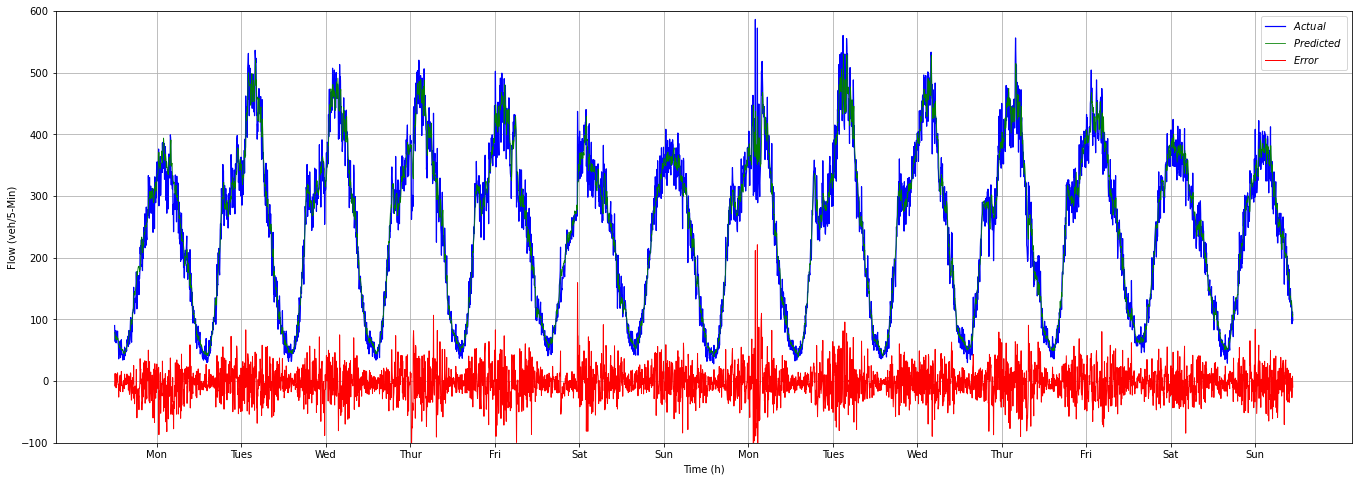

In [46]:
# Create Figure (empty canvas)
fig = plt.figure(figsize=(18,6))

# Add set of axes to figure
axes = fig.add_axes([0, 0, 1, 1]) # left, bottom, width, height (range 0 to 1)

# Plot on that set of axes
axes.plot(yv5, lw=1.2, label=r'$Actual$', color='blue')
axes.plot(test_predictions5, lw=0.8, label=r'$Predicted$', color='green')
axes.plot((yv5-test_predictions5), lw=1, label=r'$Error$', color='red')

#axes.set_xlim(0,24)
axes.set_ylim(-100,600)
axes.set_xlabel('Time (h)')
axes.set_ylabel('Flow (veh/5-Min)')

axes.legend(loc=1)
axes.grid()

axes.set_xticks([144 + i for i in range(0, 4032, 288)])
axes.set_xticklabels(['Mon', 'Tues', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun']*2)

plt.show()

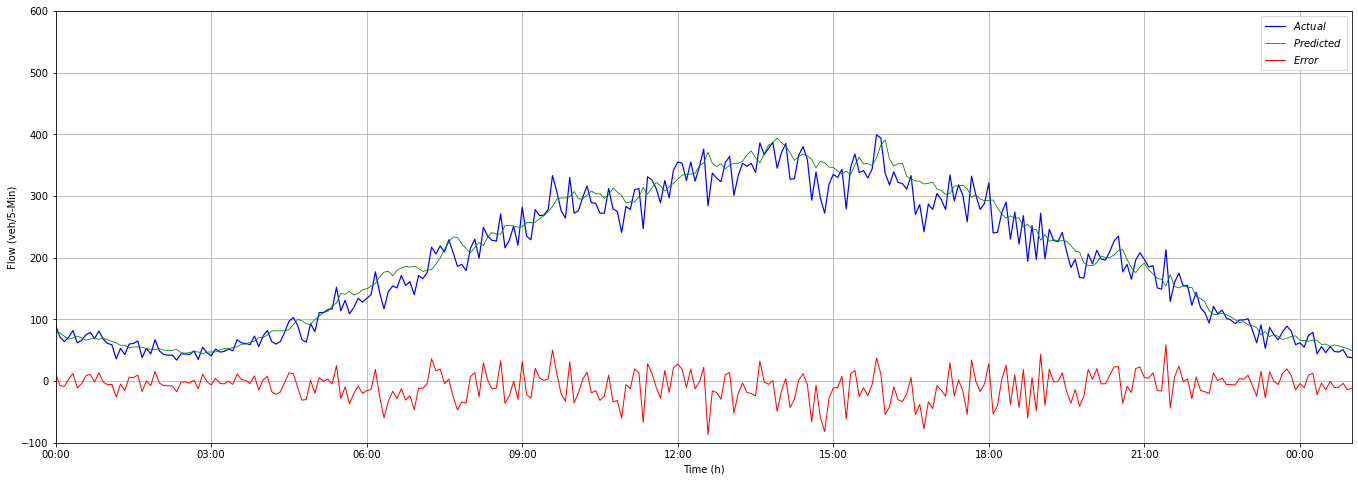

In [47]:
# Create Figure (empty canvas)
fig = plt.figure(figsize=(18,6))

# Add set of axes to figure
axes = fig.add_axes([0, 0, 1, 1]) # left, bottom, width, height (range 0 to 1)

# Plot on that set of axes
axes.plot(yv5, lw=1.2, label=r'$Actual$', color='blue')
axes.plot(test_predictions5, lw=0.8, label=r'$Predicted$', color='green')
axes.plot((yv5-test_predictions5), lw=1, label=r'$Error$', color='red')

axes.set_xlim(0,300)
axes.set_ylim(-100,600)
axes.set_xlabel('Time (h)')
axes.set_ylabel('Flow (veh/5-Min)')

axes.legend(loc=1)
axes.grid()

axes.set_xticks([0, 36, 72, 108, 144, 180, 216, 252, 288])
axes.set_xticklabels(['00:00', '03:00', '06:00', '09:00', '12:00', '15:00', '18:00', '21:00','00:00'])

plt.show()

# 15 mins ahead

In [136]:
def build_model_15(hp):
    # Inputs
    channel_Wide = keras.layers.Input(shape=Wide_train_15.shape[1:], name="WideInput")
    channel_Deep = keras.layers.Input(shape=(None, n_steps, n_features, n_channels), name="DeepInput")
    
    # Wide Model
    Wide_15 = keras.layers.Dense(
        units=hp.Int("units_NN", min_value=10, max_value=100, step=1), activation="relu"
    )(channel_Wide)
    
    # Deep Model
    # CNN 
    CNN_15 = keras.layers.TimeDistributed(
        keras.layers.Conv2D(filters=hp.Int("filters", min_value=32, max_value=512, step=32),
                            kernel_size=hp.Choice("kernel_size", [2, 3]), activation='relu'))(channel_Deep)
    flatten_15 = keras.layers.TimeDistributed(keras.layers.Flatten())(CNN_15)
    # LSTM          
    LSTM_15 = keras.layers.LSTM(units=hp.Int("units_LSTM", min_value=1, max_value=100, step=1), 
                                activation='relu')(flatten_15)
    
    # Concatenation 
    concat = keras.layers.concatenate([Wide_15, LSTM_15])
    
    # Output
    output = keras.layers.Dense(1, name= "output")(concat)
    
    # Model
    model_15 = keras.Model(inputs=[channel_Wide,channel_Deep], outputs=[output])

    # Compile
    model_15.compile(optimizer=keras.optimizers.Adam(hp.Choice("learning_rate", [1e-2, 1e-3, 1e-4])), 
        loss='mse',metrics=['MeanAbsoluteError','RootMeanSquaredError','MeanAbsolutePercentageError'])
                    
    return model_15

In [137]:
tuner15 = RandomSearch(
    build_model_15,
    objective="val_loss",
    max_trials=60,
    executions_per_trial=5,
    overwrite=False,
    directory=os.path.normpath('C:/RunsOak'),
    project_name="7d-CNN-LSTM-15",
)

INFO:tensorflow:Reloading Oracle from existing project C:\RunsOak\7d-CNN-LSTM-15\oracle.json
INFO:tensorflow:Reloading Tuner from C:\RunsOak\7d-CNN-LSTM-15\tuner0.json


In [138]:
tuner15.search_space_summary()

Search space summary
Default search space size: 5
units_NN (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 100, 'step': 1, 'sampling': None}
filters (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
kernel_size (Choice)
{'default': 2, 'conditions': [], 'values': [2, 3], 'ordered': True}
units_LSTM (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 100, 'step': 1, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [139]:
tuner15.search((Wt15,Xt15), yt15, epochs=200,
            validation_split = val_percent,
            callbacks=[early_stop], 
            verbose=2)

INFO:tensorflow:Oracle triggered exit


In [140]:
tuner15.results_summary(1)

Results summary
Results in C:\RunsOak\7d-CNN-LSTM-15
Showing 1 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
units_NN: 18
filters: 256
kernel_size: 2
units_LSTM: 55
learning_rate: 0.001
Score: 0.001979599567130208


### Best model

In [141]:
best_hp15 = tuner15.get_best_hyperparameters()[0]
model15 = tuner15.hypermodel.build(best_hp15)

In [142]:
scaler_filename = "Best_HP/7d-ConvLSTM-15"
joblib.dump(best_hp15, scaler_filename) 

['Best_HP/7d-ConvLSTM-15']

In [143]:
model15.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
DeepInput (InputLayer)          [(None, None, 5, 6,  0                                            
__________________________________________________________________________________________________
time_distributed (TimeDistribut (None, None, 4, 5, 2 1280        DeepInput[0][0]                  
__________________________________________________________________________________________________
WideInput (InputLayer)          [(None, 14)]         0                                            
__________________________________________________________________________________________________
time_distributed_1 (TimeDistrib (None, None, 5120)   0           time_distributed[0][0]           
_______________________________________________________________________________________

In [144]:
#model15.fit((Wt15,Xt15), yt15, 
#            epochs = 100, 
#            verbose = 0)

In [145]:
#model15.save("my_dir/7d-CNN-LSTM-15")

In [146]:
#metrics15 = pd.DataFrame(model15.history.history)

In [147]:
#metrics15[['loss']].plot()

In [148]:
MSE15  = []
MAE15  = []
RMSE15 = []
MAPE15 = []

for i in range(100):
    print(f"run: {i+1}")
    model15.fit((Wt15,Xt15), yt15, 
            epochs = 200, validation_split = val_percent,
            callbacks = [stop],
            verbose = 1)
    
    test_predictions15 = model15.predict((Wv15,Xv15))

    yv15 = scaler.inverse_transform(Test.drop('Timestamp', axis = 1))
    yv15 = yv15[17:,3]

    df = Test.drop(Test.head(17).index)
    df.reset_index(inplace = True)
    df = df.drop(columns=['index','Timestamp'])
    df['f4'] = pd.Series(test_predictions15.flatten())

    test_predictions15 = scaler.inverse_transform(df)

    test_predictions15 = test_predictions15[:,3]

    MSE15.append(mean_squared_error(yv15,test_predictions15))

    MAE15.append(mean_absolute_error(yv15,test_predictions15))

    RMSE15.append(np.sqrt(mean_squared_error(yv15,test_predictions15)))

    MAPE15.append(mean_absolute_percentage_error(yv15,test_predictions15)*100)

    
    current_mse = mean_squared_error(yv15,test_predictions15)
    if all(i > current_mse for i in MSE15):
        model15.save("my_dir/7d-CNN-LSTM-15")

eval15 = [mean(MSE15), mean(MAE15), mean(RMSE15), mean(MAPE15)]
std15 = [stdev(MSE15), stdev(MAE15), stdev(RMSE15), stdev(MAPE15)]
print(eval15)

run: 1
Epoch 1/200
1423/1423 [==============================] - 27s 19ms/step - loss: 0.0029 - mean_absolute_error: 0.0395 - root_mean_squared_error: 0.0542 - mean_absolute_percentage_error: 1237.4136 - val_loss: 0.0028 - val_mean_absolute_error: 0.0397 - val_root_mean_squared_error: 0.0529 - val_mean_absolute_percentage_error: 12.3323
Epoch 2/200
1423/1423 [==============================] - 26s 19ms/step - loss: 0.0023 - mean_absolute_error: 0.0358 - root_mean_squared_error: 0.0481 - mean_absolute_percentage_error: 1179.4868 - val_loss: 0.0021 - val_mean_absolute_error: 0.0340 - val_root_mean_squared_error: 0.0457 - val_mean_absolute_percentage_error: 11.6394
Epoch 3/200
1423/1423 [==============================] - 26s 18ms/step - loss: 0.0022 - mean_absolute_error: 0.0350 - root_mean_squared_error: 0.0471 - mean_absolute_percentage_error: 1379.8795 - val_loss: 0.0022 - val_mean_absolute_error: 0.0353 - val_root_mean_squared_error: 0.0468 - val_mean_absolute_percentage_error: 13.7384


Epoch 10/200
1423/1423 [==============================] - 26s 18ms/step - loss: 0.0020 - mean_absolute_error: 0.0330 - root_mean_squared_error: 0.0447 - mean_absolute_percentage_error: 1105.4407 - val_loss: 0.0020 - val_mean_absolute_error: 0.0328 - val_root_mean_squared_error: 0.0443 - val_mean_absolute_percentage_error: 11.0392
Epoch 11/200
1423/1423 [==============================] - 26s 18ms/step - loss: 0.0020 - mean_absolute_error: 0.0329 - root_mean_squared_error: 0.0445 - mean_absolute_percentage_error: 1077.7017 - val_loss: 0.0020 - val_mean_absolute_error: 0.0334 - val_root_mean_squared_error: 0.0452 - val_mean_absolute_percentage_error: 11.3592
Epoch 12/200
1423/1423 [==============================] - 26s 18ms/step - loss: 0.0020 - mean_absolute_error: 0.0328 - root_mean_squared_error: 0.0444 - mean_absolute_percentage_error: 1081.2076 - val_loss: 0.0033 - val_mean_absolute_error: 0.0431 - val_root_mean_squared_error: 0.0571 - val_mean_absolute_percentage_error: 12.6633
Epoc

Epoch 8/200
1423/1423 [==============================] - 26s 18ms/step - loss: 0.0019 - mean_absolute_error: 0.0320 - root_mean_squared_error: 0.0432 - mean_absolute_percentage_error: 1021.2097 - val_loss: 0.0020 - val_mean_absolute_error: 0.0329 - val_root_mean_squared_error: 0.0443 - val_mean_absolute_percentage_error: 11.1929
Epoch 9/200
1423/1423 [==============================] - 25s 18ms/step - loss: 0.0019 - mean_absolute_error: 0.0320 - root_mean_squared_error: 0.0432 - mean_absolute_percentage_error: 1001.8090 - val_loss: 0.0020 - val_mean_absolute_error: 0.0332 - val_root_mean_squared_error: 0.0448 - val_mean_absolute_percentage_error: 11.10460.0320 - root_ - ETA: 7s - loss: 0.0019 - mean_absolute_error: 0.0320 - root_mean_squared_error: 0.0432 - mean_absolute_percentage_error: 1416.93 - ETA: 7s - l
Epoch 10/200
1423/1423 [==============================] - 25s 18ms/step - loss: 0.0019 - mean_absolute_error: 0.0319 - root_mean_squared_error: 0.0432 - mean_absolute_percentage_e

1423/1423 [==============================] - 25s 17ms/step - loss: 0.0018 - mean_absolute_error: 0.0312 - root_mean_squared_error: 0.0421 - mean_absolute_percentage_error: 1073.5778 - val_loss: 0.0020 - val_mean_absolute_error: 0.0338 - val_root_mean_squared_error: 0.0450 - val_mean_absolute_percentage_error: 12.5375
Epoch 10/200
1423/1423 [==============================] - 25s 17ms/step - loss: 0.0018 - mean_absolute_error: 0.0313 - root_mean_squared_error: 0.0421 - mean_absolute_percentage_error: 966.8448 - val_loss: 0.0020 - val_mean_absolute_error: 0.0332 - val_root_mean_squared_error: 0.0447 - val_mean_absolute_percentage_error: 11.5238
run: 8
Epoch 1/200
1423/1423 [==============================] - 25s 17ms/step - loss: 0.0018 - mean_absolute_error: 0.0314 - root_mean_squared_error: 0.0424 - mean_absolute_percentage_error: 1194.4783 - val_loss: 0.0020 - val_mean_absolute_error: 0.0331 - val_root_mean_squared_error: 0.0446 - val_mean_absolute_percentage_error: 11.0624
Epoch 2/200


1423/1423 [==============================] - 25s 17ms/step - loss: 0.0016 - mean_absolute_error: 0.0298 - root_mean_squared_error: 0.0400 - mean_absolute_percentage_error: 574.0764 - val_loss: 0.0023 - val_mean_absolute_error: 0.0365 - val_root_mean_squared_error: 0.0484 - val_mean_absolute_percentage_error: 12.0346. - ETA: 1s - loss: 0.0016 - mean_absolute_error: 0.0297 - root_mean_squared_error: 0.0400 -
Epoch 10/200
1423/1423 [==============================] - 25s 17ms/step - loss: 0.0016 - mean_absolute_error: 0.0297 - root_mean_squared_error: 0.0399 - mean_absolute_percentage_error: 118.8143 - val_loss: 0.0021 - val_mean_absolute_error: 0.0339 - val_root_mean_squared_error: 0.0457 - val_mean_absolute_percentage_error: 11.3565
Epoch 11/200
1423/1423 [==============================] - 25s 17ms/step - loss: 0.0016 - mean_absolute_error: 0.0295 - root_mean_squared_error: 0.0397 - mean_absolute_percentage_error: 499.6873 - val_loss: 0.0021 - val_mean_absolute_error: 0.0337 - val_root_m

1423/1423 [==============================] - 25s 17ms/step - loss: 0.0015 - mean_absolute_error: 0.0290 - root_mean_squared_error: 0.0390 - mean_absolute_percentage_error: 149.4695 - val_loss: 0.0022 - val_mean_absolute_error: 0.0347 - val_root_mean_squared_error: 0.0467 - val_mean_absolute_percentage_error: 11.3345
Epoch 6/200
1423/1423 [==============================] - 25s 17ms/step - loss: 0.0015 - mean_absolute_error: 0.0289 - root_mean_squared_error: 0.0388 - mean_absolute_percentage_error: 349.6750 - val_loss: 0.0022 - val_mean_absolute_error: 0.0346 - val_root_mean_squared_error: 0.0469 - val_mean_absolute_percentage_error: 11.6124
Epoch 7/200
1423/1423 [==============================] - 25s 17ms/step - loss: 0.0015 - mean_absolute_error: 0.0288 - root_mean_squared_error: 0.0387 - mean_absolute_percentage_error: 23.6985 - val_loss: 0.0022 - val_mean_absolute_error: 0.0347 - val_root_mean_squared_error: 0.0467 - val_mean_absolute_percentage_error: 11.3019
run: 16
Epoch 1/200
142

1423/1423 [==============================] - 25s 18ms/step - loss: 0.0014 - mean_absolute_error: 0.0275 - root_mean_squared_error: 0.0369 - mean_absolute_percentage_error: 263.7231 - val_loss: 0.0023 - val_mean_absolute_error: 0.0352 - val_root_mean_squared_error: 0.0476 - val_mean_absolute_percentage_error: 11.6024
Epoch 6/200
1423/1423 [==============================] - 25s 18ms/step - loss: 0.0014 - mean_absolute_error: 0.0276 - root_mean_squared_error: 0.0369 - mean_absolute_percentage_error: 564.9450 - val_loss: 0.0024 - val_mean_absolute_error: 0.0357 - val_root_mean_squared_error: 0.0487 - val_mean_absolute_percentage_error: 11.7613
Epoch 7/200
1423/1423 [==============================] - 25s 18ms/step - loss: 0.0013 - mean_absolute_error: 0.0273 - root_mean_squared_error: 0.0366 - mean_absolute_percentage_error: 231.8713 - val_loss: 0.0023 - val_mean_absolute_error: 0.0354 - val_root_mean_squared_error: 0.0483 - val_mean_absolute_percentage_error: 11.7392
Epoch 8/200
1423/1423 

1423/1423 [==============================] - 25s 17ms/step - loss: 0.0013 - mean_absolute_error: 0.0265 - root_mean_squared_error: 0.0355 - mean_absolute_percentage_error: 513.8680 - val_loss: 0.0024 - val_mean_absolute_error: 0.0363 - val_root_mean_squared_error: 0.0492 - val_mean_absolute_percentage_error: 12.6155
Epoch 3/200
1423/1423 [==============================] - 24s 17ms/step - loss: 0.0012 - mean_absolute_error: 0.0264 - root_mean_squared_error: 0.0354 - mean_absolute_percentage_error: 364.5319 - val_loss: 0.0024 - val_mean_absolute_error: 0.0362 - val_root_mean_squared_error: 0.0493 - val_mean_absolute_percentage_error: 11.7391
Epoch 4/200
1423/1423 [==============================] - 24s 17ms/step - loss: 0.0012 - mean_absolute_error: 0.0264 - root_mean_squared_error: 0.0352 - mean_absolute_percentage_error: 37.4146 - val_loss: 0.0025 - val_mean_absolute_error: 0.0367 - val_root_mean_squared_error: 0.0498 - val_mean_absolute_percentage_error: 11.9093
Epoch 5/200
1423/1423 [

Epoch 5/200
1423/1423 [==============================] - 25s 17ms/step - loss: 0.0012 - mean_absolute_error: 0.0259 - root_mean_squared_error: 0.0345 - mean_absolute_percentage_error: 128.8822 - val_loss: 0.0025 - val_mean_absolute_error: 0.0364 - val_root_mean_squared_error: 0.0500 - val_mean_absolute_percentage_error: 11.9627
Epoch 6/200
1423/1423 [==============================] - 25s 18ms/step - loss: 0.0012 - mean_absolute_error: 0.0258 - root_mean_squared_error: 0.0345 - mean_absolute_percentage_error: 130.7785 - val_loss: 0.0025 - val_mean_absolute_error: 0.0365 - val_root_mean_squared_error: 0.0503 - val_mean_absolute_percentage_error: 12.0428
Epoch 7/200
1423/1423 [==============================] - 25s 17ms/step - loss: 0.0012 - mean_absolute_error: 0.0257 - root_mean_squared_error: 0.0343 - mean_absolute_percentage_error: 576.0297 - val_loss: 0.0026 - val_mean_absolute_error: 0.0368 - val_root_mean_squared_error: 0.0508 - val_mean_absolute_percentage_error: 12.2729
run: 32
Ep

1423/1423 [==============================] - 25s 17ms/step - loss: 0.0011 - mean_absolute_error: 0.0250 - root_mean_squared_error: 0.0333 - mean_absolute_percentage_error: 350.9065 - val_loss: 0.0027 - val_mean_absolute_error: 0.0378 - val_root_mean_squared_error: 0.0523 - val_mean_absolute_percentage_error: 12.1199
Epoch 2/200
1423/1423 [==============================] - 25s 18ms/step - loss: 0.0011 - mean_absolute_error: 0.0250 - root_mean_squared_error: 0.0333 - mean_absolute_percentage_error: 75.4977 - val_loss: 0.0027 - val_mean_absolute_error: 0.0377 - val_root_mean_squared_error: 0.0520 - val_mean_absolute_percentage_error: 12.1756_absolute_error: 0.0249 - root_mean_squared_error: 0.0332 - me - ETA: 0s - loss: 0.0011 - mean_absolute_error: 0.0250 - root_mean_squared_error: 0.0332 - mean_absolute_percentage_erro
Epoch 3/200
1423/1423 [==============================] - 25s 17ms/step - loss: 0.0011 - mean_absolute_error: 0.0249 - root_mean_squared_error: 0.0332 - mean_absolute_perc

1423/1423 [==============================] - 25s 17ms/step - loss: 9.8683e-04 - mean_absolute_error: 0.0236 - root_mean_squared_error: 0.0314 - mean_absolute_percentage_error: 27.1024 - val_loss: 0.0027 - val_mean_absolute_error: 0.0380 - val_root_mean_squared_error: 0.0521 - val_mean_absolute_percentage_error: 12.4458.0236 - root_mean_squared_error: 0. - ETA: 2s - loss: 9.8261e-04 - mean_absolute_error: 0.0236 - root_mean_squared_error: 0.0313 - mean_absolute_percent - ETA: 1s - loss: 9.8637e-04 - mean_absolute_error: 0.0236 - root_mean_squared_error: 0.0314 - mean_absolut
Epoch 6/200
1423/1423 [==============================] - 25s 17ms/step - loss: 9.8262e-04 - mean_absolute_error: 0.0236 - root_mean_squared_error: 0.0313 - mean_absolute_percentage_error: 333.3008 - val_loss: 0.0027 - val_mean_absolute_error: 0.0382 - val_root_mean_squared_error: 0.0523 - val_mean_absolute_percentage_error: 12.4670
Epoch 7/200
1423/1423 [==============================] - 25s 17ms/step - loss: 9.7434

1423/1423 [==============================] - 25s 18ms/step - loss: 8.9474e-04 - mean_absolute_error: 0.0226 - root_mean_squared_error: 0.0299 - mean_absolute_percentage_error: 121.6783 - val_loss: 0.0030 - val_mean_absolute_error: 0.0401 - val_root_mean_squared_error: 0.0547 - val_mean_absolute_percentage_error: 12.7072
run: 49
Epoch 1/200
1423/1423 [==============================] - 25s 18ms/step - loss: 9.1485e-04 - mean_absolute_error: 0.0228 - root_mean_squared_error: 0.0302 - mean_absolute_percentage_error: 344.3177 - val_loss: 0.0028 - val_mean_absolute_error: 0.0391 - val_root_mean_squared_error: 0.0533 - val_mean_absolute_percentage_error: 12.5471or: 0.0305 - mean_absolut - ETA - ETA - ETA: 1s - loss: 9.1985e-04 - mean_absolute_error: 0.0229 - root_mean_squared_error: 0.0303 - mean_absolute_percentage_error - ETA: 1s - loss: 9.1916e-04 - mean_absolute_error: 0.0228 - root_mean_squared_error: 0.0303 - mean_absol - ETA: 0s - loss: 9.1724e-04 - mean_absolute_error: 0.0228 - root_m

1423/1423 [==============================] - 25s 18ms/step - loss: 8.2931e-04 - mean_absolute_error: 0.0218 - root_mean_squared_error: 0.0288 - mean_absolute_percentage_error: 176.5354 - val_loss: 0.0030 - val_mean_absolute_error: 0.0400 - val_root_mean_squared_error: 0.0546 - val_mean_absolute_percentage_error: 12.8911error: 0
Epoch 6/200
1423/1423 [==============================] - 25s 18ms/step - loss: 8.3048e-04 - mean_absolute_error: 0.0218 - root_mean_squared_error: 0.0288 - mean_absolute_percentage_error: 241.3134 - val_loss: 0.0030 - val_mean_absolute_error: 0.0403 - val_root_mean_squared_error: 0.0552 - val_mean_absolute_percentage_error: 13.2656
Epoch 7/200
1423/1423 [==============================] - 25s 18ms/step - loss: 8.1619e-04 - mean_absolute_error: 0.0216 - root_mean_squared_error: 0.0286 - mean_absolute_percentage_error: 268.9604 - val_loss: 0.0029 - val_mean_absolute_error: 0.0395 - val_root_mean_squared_error: 0.0539 - val_mean_absolute_percentage_error: 12.8458
Ep

1423/1423 [==============================] - 25s 18ms/step - loss: 7.2731e-04 - mean_absolute_error: 0.0205 - root_mean_squared_error: 0.0270 - mean_absolute_percentage_error: 66.0728 - val_loss: 0.0033 - val_mean_absolute_error: 0.0416 - val_root_mean_squared_error: 0.0571 - val_mean_absolute_percentage_error: 13.2589error: 0.0204 - root_mean_squared_error:  - ETA: 2s - loss: 7.2185e-04 - mean_absolute_error: 0.0204 - root_mean_squared_error: 0.0269 
run: 58
Epoch 1/200
1423/1423 [==============================] - 25s 18ms/step - loss: 7.4955e-04 - mean_absolute_error: 0.0208 - root_mean_squared_error: 0.0274 - mean_absolute_percentage_error: 146.7199 - val_loss: 0.0032 - val_mean_absolute_error: 0.0414 - val_root_mean_squared_error: 0.0567 - val_mean_absolute_percentage_error: 13.0020
Epoch 2/200
1423/1423 [==============================] - 25s 18ms/step - loss: 7.3145e-04 - mean_absolute_error: 0.0205 - root_mean_squared_error: 0.0270 - mean_absolute_percentage_error: 46.4705 - val_

1423/1423 [==============================] - 25s 17ms/step - loss: 6.7377e-04 - mean_absolute_error: 0.0197 - root_mean_squared_error: 0.0260 - mean_absolute_percentage_error: 160.2225 - val_loss: 0.0033 - val_mean_absolute_error: 0.0417 - val_root_mean_squared_error: 0.0571 - val_mean_absolute_percentage_error: 13.3691
Epoch 6/200
1423/1423 [==============================] - 25s 17ms/step - loss: 6.6634e-04 - mean_absolute_error: 0.0196 - root_mean_squared_error: 0.0258 - mean_absolute_percentage_error: 105.8978 - val_loss: 0.0032 - val_mean_absolute_error: 0.0415 - val_root_mean_squared_error: 0.0567 - val_mean_absolute_percentage_error: 13.0277
Epoch 7/200
1423/1423 [==============================] - 25s 17ms/step - loss: 6.6592e-04 - mean_absolute_error: 0.0197 - root_mean_squared_error: 0.0258 - mean_absolute_percentage_error: 92.5734 - val_loss: 0.0033 - val_mean_absolute_error: 0.0418 - val_root_mean_squared_error: 0.0574 - val_mean_absolute_percentage_error: 13.6616
Epoch 8/200

1423/1423 [==============================] - 24s 17ms/step - loss: 6.1569e-04 - mean_absolute_error: 0.0189 - root_mean_squared_error: 0.0248 - mean_absolute_percentage_error: 511.8508 - val_loss: 0.0034 - val_mean_absolute_error: 0.0422 - val_root_mean_squared_error: 0.0579 - val_mean_absolute_percentage_error: 13.3790
Epoch 6/200
1423/1423 [==============================] - 24s 17ms/step - loss: 5.9692e-04 - mean_absolute_error: 0.0187 - root_mean_squared_error: 0.0244 - mean_absolute_percentage_error: 24.0381 - val_loss: 0.0034 - val_mean_absolute_error: 0.0424 - val_root_mean_squared_error: 0.0582 - val_mean_absolute_percentage_error: 13.5503
Epoch 7/200
1423/1423 [==============================] - 24s 17ms/step - loss: 6.0532e-04 - mean_absolute_error: 0.0188 - root_mean_squared_error: 0.0246 - mean_absolute_percentage_error: 25.6376 - val_loss: 0.0034 - val_mean_absolute_error: 0.0426 - val_root_mean_squared_error: 0.0582 - val_mean_absolute_percentage_error: 13.7612
Epoch 8/200


1423/1423 [==============================] - 24s 17ms/step - loss: 5.5711e-04 - mean_absolute_error: 0.0181 - root_mean_squared_error: 0.0236 - mean_absolute_percentage_error: 67.0392 - val_loss: 0.0036 - val_mean_absolute_error: 0.0434 - val_root_mean_squared_error: 0.0596 - val_mean_absolute_percentage_error: 13.5562
run: 74
Epoch 1/200
1423/1423 [==============================] - 24s 17ms/step - loss: 5.5753e-04 - mean_absolute_error: 0.0181 - root_mean_squared_error: 0.0236 - mean_absolute_percentage_error: 198.5082 - val_loss: 0.0036 - val_mean_absolute_error: 0.0437 - val_root_mean_squared_error: 0.0600 - val_mean_absolute_percentage_error: 13.6032
Epoch 2/200
1423/1423 [==============================] - 24s 17ms/step - loss: 5.5914e-04 - mean_absolute_error: 0.0180 - root_mean_squared_error: 0.0236 - mean_absolute_percentage_error: 376.8841 - val_loss: 0.0034 - val_mean_absolute_error: 0.0425 - val_root_mean_squared_error: 0.0582 - val_mean_absolute_percentage_error: 13.1726
Epo

1423/1423 [==============================] - 24s 17ms/step - loss: 5.2368e-04 - mean_absolute_error: 0.0175 - root_mean_squared_error: 0.0229 - mean_absolute_percentage_error: 307.3555 - val_loss: 0.0036 - val_mean_absolute_error: 0.0439 - val_root_mean_squared_error: 0.0601 - val_mean_absolute_percentage_error: 14.0083
run: 81
Epoch 1/200
1423/1423 [==============================] - 23s 16ms/step - loss: 5.3374e-04 - mean_absolute_error: 0.0177 - root_mean_squared_error: 0.0231 - mean_absolute_percentage_error: 417.3947 - val_loss: 0.0035 - val_mean_absolute_error: 0.0433 - val_root_mean_squared_error: 0.0594 - val_mean_absolute_percentage_error: 13.5613
Epoch 2/200
1423/1423 [==============================] - 23s 16ms/step - loss: 5.3130e-04 - mean_absolute_error: 0.0177 - root_mean_squared_error: 0.0230 - mean_absolute_percentage_error: 180.3249 - val_loss: 0.0037 - val_mean_absolute_error: 0.0440 - val_root_mean_squared_error: 0.0608 - val_mean_absolute_percentage_error: 13.9178
Ep

1423/1423 [==============================] - 23s 16ms/step - loss: 4.8699e-04 - mean_absolute_error: 0.0169 - root_mean_squared_error: 0.0221 - mean_absolute_percentage_error: 137.7977 - val_loss: 0.0038 - val_mean_absolute_error: 0.0448 - val_root_mean_squared_error: 0.0614 - val_mean_absolute_percentage_error: 13.8441
Epoch 9/200
1423/1423 [==============================] - 23s 16ms/step - loss: 4.8998e-04 - mean_absolute_error: 0.0170 - root_mean_squared_error: 0.0221 - mean_absolute_percentage_error: 71.3574 - val_loss: 0.0036 - val_mean_absolute_error: 0.0434 - val_root_mean_squared_error: 0.0596 - val_mean_absolute_percentage_error: 13.5415
Epoch 10/200
1423/1423 [==============================] - 23s 16ms/step - loss: 4.7994e-04 - mean_absolute_error: 0.0168 - root_mean_squared_error: 0.0219 - mean_absolute_percentage_error: 206.1060 - val_loss: 0.0036 - val_mean_absolute_error: 0.0438 - val_root_mean_squared_error: 0.0601 - val_mean_absolute_percentage_error: 13.8495
run: 87
Ep

1423/1423 [==============================] - 23s 16ms/step - loss: 4.5577e-04 - mean_absolute_error: 0.0164 - root_mean_squared_error: 0.0213 - mean_absolute_percentage_error: 468.3195 - val_loss: 0.0037 - val_mean_absolute_error: 0.0447 - val_root_mean_squared_error: 0.0609 - val_mean_absolute_percentage_error: 13.8397
Epoch 9/200
1423/1423 [==============================] - 23s 16ms/step - loss: 4.5216e-04 - mean_absolute_error: 0.0163 - root_mean_squared_error: 0.0213 - mean_absolute_percentage_error: 364.0028 - val_loss: 0.0038 - val_mean_absolute_error: 0.0443 - val_root_mean_squared_error: 0.0613 - val_mean_absolute_percentage_error: 13.8451
Epoch 10/200
1423/1423 [==============================] - 23s 16ms/step - loss: 4.5012e-04 - mean_absolute_error: 0.0163 - root_mean_squared_error: 0.0212 - mean_absolute_percentage_error: 254.5538 - val_loss: 0.0037 - val_mean_absolute_error: 0.0444 - val_root_mean_squared_error: 0.0611 - val_mean_absolute_percentage_error: 13.8849
run: 92
E

1423/1423 [==============================] - 23s 16ms/step - loss: 4.2980e-04 - mean_absolute_error: 0.0160 - root_mean_squared_error: 0.0207 - mean_absolute_percentage_error: 51.5308 - val_loss: 0.0038 - val_mean_absolute_error: 0.0447 - val_root_mean_squared_error: 0.0620 - val_mean_absolute_percentage_error: 13.9848
run: 98
Epoch 1/200
1423/1423 [==============================] - 23s 16ms/step - loss: 4.3422e-04 - mean_absolute_error: 0.0161 - root_mean_squared_error: 0.0208 - mean_absolute_percentage_error: 13.5112 - val_loss: 0.0038 - val_mean_absolute_error: 0.0448 - val_root_mean_squared_error: 0.0618 - val_mean_absolute_percentage_error: 13.8928
Epoch 2/200
1423/1423 [==============================] - 23s 16ms/step - loss: 4.3108e-04 - mean_absolute_error: 0.0160 - root_mean_squared_error: 0.0208 - mean_absolute_percentage_error: 313.1502 - val_loss: 0.0038 - val_mean_absolute_error: 0.0451 - val_root_mean_squared_error: 0.0620 - val_mean_absolute_percentage_error: 13.8174
Epoc

In [149]:
model15 = keras.models.load_model("my_dir/7d-CNN-LSTM-15")

In [150]:
runs = {'MSE': MSE15, 'MAE': MAE15, 'RMSE': RMSE15, 'MAPE': MAPE15}
table15 = pd.DataFrame(data=runs)
table15.to_csv("Results/Runs/7d-CNN-LSTM-15")

In [151]:
pd.read_csv("Results/Runs/7d-CNN-LSTM-15", index_col=0)

,MSE,MAE,RMSE,MAPE
0,858.499728,21.627014,29.300166,10.508232
1,831.088883,21.201066,28.828612,10.432267
2,841.506223,21.383994,29.008727,10.466068
3,844.006047,21.389600,29.051782,10.616245
4,843.062099,21.383377,29.035532,10.442188
...,...,...,...,...
95,1665.046299,28.597533,40.804979,13.206964
96,1662.153156,28.574735,40.769513,13.132594
97,1668.590610,28.890996,40.848386,13.266380
98,1640.593668,28.535667,40.504243,13.180910


In [156]:
eval15

[1235.4703038444475, 25.048143019524897, 34.9216380932171, 11.87358330354113]

### Evaluation on inverse_transform

In [152]:
test_predictions15 = model15.predict((Wv15,Xv15))

yv15 = scaler.inverse_transform(Test.drop('Timestamp', axis = 1))
yv15 = yv15[17:,3]

df = Test.drop(Test.head(17).index)
df.reset_index(inplace = True)
df = df.drop(columns=['index','Timestamp'])
df['f4'] = pd.Series(test_predictions15.flatten())

test_predictions15 = scaler.inverse_transform(df)

test_predictions15 = test_predictions15[:,3]

#MSE15 = mean_squared_error(yv15,test_predictions15)

#MAE15 = mean_absolute_error(yv15,test_predictions15)

#RMSE15 = np.sqrt(MSE15)

#MAPE15 = mean_absolute_percentage_error(yv15,test_predictions15)*100

#eval15 = [MSE15, MAE15, RMSE15, MAPE15]
#print(eval15)

In [153]:
RA10 = ra.RA_10(np.asarray(yv15), np.asarray(test_predictions15))
RA15 = ra.RA_15(np.asarray(yv15), np.asarray(test_predictions15))
RA20 = ra.RA_20(np.asarray(yv15), np.asarray(test_predictions15))

res15 = [RA10, RA15, RA20]
print(res15)

[56.612702366127024, 75.04358655043588, 85.95267745952677]


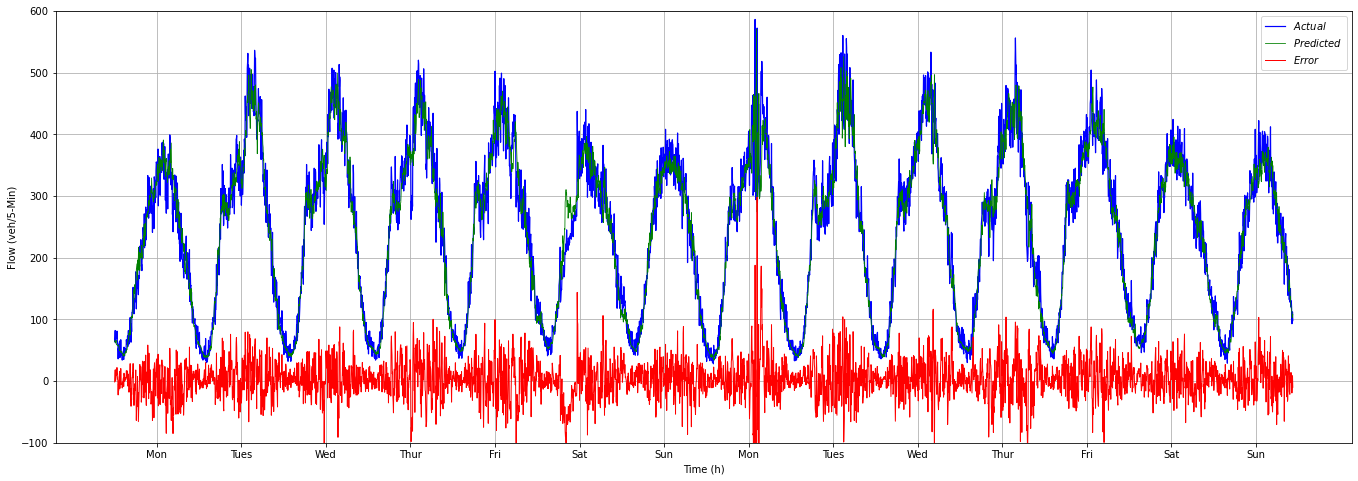

In [154]:
# Create Figure (empty canvas)
fig = plt.figure(figsize=(18,6))

# Add set of axes to figure
axes = fig.add_axes([0, 0, 1, 1]) # left, bottom, width, height (range 0 to 1)

# Plot on that set of axes
axes.plot(yv15, lw=1.2, label=r'$Actual$', color='blue')
axes.plot(test_predictions15, lw=0.8, label=r'$Predicted$', color='green')
axes.plot((yv15-test_predictions15), lw=1, label=r'$Error$', color='red')

#axes.set_xlim(0,24)
axes.set_ylim(-100,600)
axes.set_xlabel('Time (h)')
axes.set_ylabel('Flow (veh/5-Min)')

axes.legend(loc=1)
axes.grid()

axes.set_xticks([144 + i for i in range(0, 4032, 288)])
axes.set_xticklabels(['Mon', 'Tues', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun']*2)

plt.show()

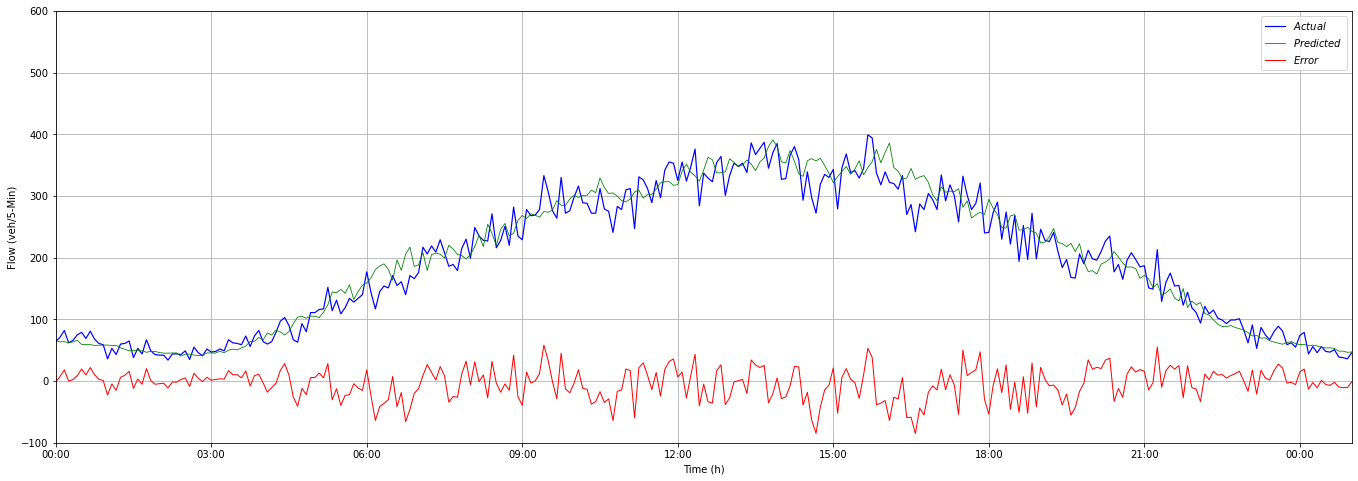

In [155]:
# Create Figure (empty canvas)
fig = plt.figure(figsize=(18,6))

# Add set of axes to figure
axes = fig.add_axes([0, 0, 1, 1]) # left, bottom, width, height (range 0 to 1)

# Plot on that set of axes
axes.plot(yv15, lw=1.2, label=r'$Actual$', color='blue')
axes.plot(test_predictions15, lw=0.8, label=r'$Predicted$', color='green')
axes.plot((yv15-test_predictions15), lw=1, label=r'$Error$', color='red')

axes.set_xlim(0,300)
axes.set_ylim(-100,600)
axes.set_xlabel('Time (h)')
axes.set_ylabel('Flow (veh/5-Min)')

axes.legend(loc=1)
axes.grid()

axes.set_xticks([0, 36, 72, 108, 144, 180, 216, 252, 288])
axes.set_xticklabels(['00:00', '03:00', '06:00', '09:00', '12:00', '15:00', '18:00', '21:00','00:00'])

plt.show()

# 30 mins ahead

In [66]:
def build_model_30(hp):
    # Inputs
    channel_Wide = keras.layers.Input(shape=Wide_train_30.shape[1:], name="WideInput")
    channel_Deep = keras.layers.Input(shape=(None, n_steps, n_features, n_channels), name="DeepInput")
    
    # Wide Model
    Wide_30 = keras.layers.Dense(
        units=hp.Int("units_NN", min_value=10, max_value=100, step=1), activation="relu"
    )(channel_Wide)
    
    # Deep Model
    # CNN 
    CNN_30 = keras.layers.TimeDistributed(
        keras.layers.Conv2D(filters=hp.Int("filters", min_value=32, max_value=512, step=32),
                            kernel_size=hp.Choice("kernel_size", [2, 3]), activation='relu'))(channel_Deep)
    flatten_30 = keras.layers.TimeDistributed(keras.layers.Flatten())(CNN_30)
    # LSTM          
    LSTM_30 = keras.layers.LSTM(units=hp.Int("units_LSTM", min_value=1, max_value=100, step=1), 
                                activation='relu')(flatten_30)
    
    # Concatenation 
    concat = keras.layers.concatenate([Wide_30, LSTM_30])
    
    # Output
    output = keras.layers.Dense(1, name= "output")(concat)
    
    # Model
    model_30 = keras.Model(inputs=[channel_Wide,channel_Deep], outputs=[output])

    # Compile
    model_30.compile(optimizer=keras.optimizers.Adam(hp.Choice("learning_rate", [1e-2, 1e-3, 1e-4])), 
        loss='mse',metrics=['MeanAbsoluteError','RootMeanSquaredError','MeanAbsolutePercentageError'])
                    
    return model_30

In [67]:
tuner30 = RandomSearch(
    build_model_30,
    objective="val_loss",
    max_trials=60,
    executions_per_trial=5,
    overwrite=False,
    directory=os.path.normpath('C:/RunsOak'),
    project_name="7d-CNN-LSTM-30",
)

INFO:tensorflow:Reloading Oracle from existing project C:\RunsOak\7d-CNN-LSTM-30\oracle.json
INFO:tensorflow:Reloading Tuner from C:\RunsOak\7d-CNN-LSTM-30\tuner0.json


In [68]:
tuner30.search_space_summary()

Search space summary
Default search space size: 5
units_NN (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 100, 'step': 1, 'sampling': None}
filters (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
kernel_size (Choice)
{'default': 2, 'conditions': [], 'values': [2, 3], 'ordered': True}
units_LSTM (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 100, 'step': 1, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [69]:
tuner30.search((Wt30,Xt30), yt30, epochs=200,
            validation_split = val_percent,
            callbacks=[early_stop],
            verbose=2)

INFO:tensorflow:Oracle triggered exit


In [70]:
tuner30.results_summary(1)

Results summary
Results in C:\RunsOak\7d-CNN-LSTM-30
Showing 1 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
units_NN: 20
filters: 256
kernel_size: 3
units_LSTM: 92
learning_rate: 0.001
Score: 0.002102135494351387


### Best model

In [71]:
best_hp30 = tuner30.get_best_hyperparameters()[0]
model30 = tuner30.hypermodel.build(best_hp30)

In [72]:
scaler_filename = "7d-ConvLSTM-30"
joblib.dump(best_hp30, scaler_filename) 

['7d-ConvLSTM-30']

In [73]:
model30.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
DeepInput (InputLayer)          [(None, None, 5, 6,  0                                            
__________________________________________________________________________________________________
time_distributed (TimeDistribut (None, None, 3, 4, 2 2560        DeepInput[0][0]                  
__________________________________________________________________________________________________
WideInput (InputLayer)          [(None, 14)]         0                                            
__________________________________________________________________________________________________
time_distributed_1 (TimeDistrib (None, None, 3072)   0           time_distributed[0][0]           
_______________________________________________________________________________________

In [74]:
#model30.fit((Wt30,Xt30), yt30, 
#            epochs = 100, 
#            verbose = 0)

In [75]:
#model30.save("my_dir/7d-CNN-LSTM-30")

In [76]:
#metrics30 = pd.DataFrame(model30.history.history)

In [77]:
#metrics30[['loss']].plot()

In [78]:
MSE30  = []
MAE30  = []
RMSE30 = []
MAPE30 = []

for i in range(100):
    print(f"run: {i+1}")
    model30.fit((Wt30,Xt30), yt30, 
            epochs = 200, validation_split = val_percent,
            callbacks = [stop],
            verbose = 1)
    
    test_predictions30 = model30.predict((Wv30,Xv30))

    yv30 = scaler.inverse_transform(Test.drop('Timestamp', axis = 1))
    yv30 = yv30[20:,3]

    df = Test.drop(Test.head(20).index)
    df.reset_index(inplace = True)
    df = df.drop(columns=['index','Timestamp'])
    df['f4'] = pd.Series(test_predictions30.flatten())

    test_predictions30 = scaler.inverse_transform(df)

    test_predictions30 = test_predictions30[:,3]

    MSE30.append(mean_squared_error(yv30,test_predictions30))

    MAE30.append(mean_absolute_error(yv30,test_predictions30))

    RMSE30.append(np.sqrt(mean_squared_error(yv30,test_predictions30)))

    MAPE30.append(mean_absolute_percentage_error(yv30,test_predictions30)*100)

    
    current_mse = mean_squared_error(yv30,test_predictions30)
    if all(i > current_mse for i in MSE30):
        model30.save("my_dir/7d-CNN-LSTM-30")

eval30 = [mean(MSE30), mean(MAE30), mean(RMSE30), mean(MAPE30)]
std30 = [stdev(MSE30), stdev(MAE30), stdev(RMSE30), stdev(MAPE30)]
print(eval30)

run: 1
Epoch 1/200
1422/1422 [==============================] - 49s 35ms/step - loss: 0.0033 - mean_absolute_error: 0.0414 - root_mean_squared_error: 0.0573 - mean_absolute_percentage_error: 1267.6982 - val_loss: 0.0024 - val_mean_absolute_error: 0.0369 - val_root_mean_squared_error: 0.0492 - val_mean_absolute_percentage_error: 12.8146
Epoch 2/200
1422/1422 [==============================] - 49s 35ms/step - loss: 0.0026 - mean_absolute_error: 0.0375 - root_mean_squared_error: 0.0506 - mean_absolute_percentage_error: 1002.5928 - val_loss: 0.0022 - val_mean_absolute_error: 0.0350 - val_root_mean_squared_error: 0.0472 - val_mean_absolute_percentage_error: 12.1683
Epoch 3/200
1422/1422 [==============================] - 48s 34ms/step - loss: 0.0025 - mean_absolute_error: 0.0369 - root_mean_squared_error: 0.0497 - mean_absolute_percentage_error: 1099.8351 - val_loss: 0.0025 - val_mean_absolute_error: 0.0371 - val_root_mean_squared_error: 0.0497 - val_mean_absolute_percentage_error: 11.8694


Epoch 3/200
1422/1422 [==============================] - 49s 35ms/step - loss: 0.0022 - mean_absolute_error: 0.0344 - root_mean_squared_error: 0.0464 - mean_absolute_percentage_error: 808.8282 - val_loss: 0.0021 - val_mean_absolute_error: 0.0343 - val_root_mean_squared_error: 0.0459 - val_mean_absolute_percentage_error: 11.4808
Epoch 4/200
1422/1422 [==============================] - 49s 35ms/step - loss: 0.0021 - mean_absolute_error: 0.0342 - root_mean_squared_error: 0.0463 - mean_absolute_percentage_error: 788.5790 - val_loss: 0.0023 - val_mean_absolute_error: 0.0355 - val_root_mean_squared_error: 0.0483 - val_mean_absolute_percentage_error: 12.1423.0343 - root_mean_squared_error: 0.0463 - mean_absolute_percentage_e
Epoch 5/200
1422/1422 [==============================] - 49s 34ms/step - loss: 0.0021 - mean_absolute_error: 0.0342 - root_mean_squared_error: 0.0462 - mean_absolute_percentage_error: 600.9069 - val_loss: 0.0021 - val_mean_absolute_error: 0.0341 - val_root_mean_squared_er

1422/1422 [==============================] - 48s 34ms/step - loss: 0.0020 - mean_absolute_error: 0.0329 - root_mean_squared_error: 0.0445 - mean_absolute_percentage_error: 509.5396 - val_loss: 0.0021 - val_mean_absolute_error: 0.0344 - val_root_mean_squared_error: 0.0463 - val_mean_absolute_percentage_error: 12.1002: 4s - loss: 0.0020 - mean_absolute_error: 0.0330 - root_mean_squared_error: 0.0 - ETA: 3s - loss: 0.0020 - mean
Epoch 9/200
1422/1422 [==============================] - 47s 33ms/step - loss: 0.0020 - mean_absolute_error: 0.0328 - root_mean_squared_error: 0.0444 - mean_absolute_percentage_error: 371.2388 - val_loss: 0.0021 - val_mean_absolute_error: 0.0343 - val_root_mean_squared_error: 0.0460 - val_mean_absolute_percentage_error: 11.5522
run: 7
Epoch 1/200
1422/1422 [==============================] - 48s 34ms/step - loss: 0.0020 - mean_absolute_error: 0.0332 - root_mean_squared_error: 0.0448 - mean_absolute_percentage_error: 628.5856 - val_loss: 0.0021 - val_mean_absolute_e

1422/1422 [==============================] - 49s 34ms/step - loss: 0.0019 - mean_absolute_error: 0.0319 - root_mean_squared_error: 0.0431 - mean_absolute_percentage_error: 481.1246 - val_loss: 0.0021 - val_mean_absolute_error: 0.0343 - val_root_mean_squared_error: 0.0462 - val_mean_absolute_percentage_error: 11.4279
Epoch 13/200
1422/1422 [==============================] - 49s 34ms/step - loss: 0.0019 - mean_absolute_error: 0.0319 - root_mean_squared_error: 0.0431 - mean_absolute_percentage_error: 312.2776 - val_loss: 0.0022 - val_mean_absolute_error: 0.0346 - val_root_mean_squared_error: 0.0469 - val_mean_absolute_percentage_error: 11.8162
run: 12
Epoch 1/200
1422/1422 [==============================] - 49s 35ms/step - loss: 0.0019 - mean_absolute_error: 0.0321 - root_mean_squared_error: 0.0433 - mean_absolute_percentage_error: 223.3980 - val_loss: 0.0022 - val_mean_absolute_error: 0.0350 - val_root_mean_squared_error: 0.0469 - val_mean_absolute_percentage_error: 11.5231
Epoch 2/200
1

Epoch 5/200
1422/1422 [==============================] - 47s 33ms/step - loss: 0.0017 - mean_absolute_error: 0.0305 - root_mean_squared_error: 0.0412 - mean_absolute_percentage_error: 90.0261 - val_loss: 0.0023 - val_mean_absolute_error: 0.0358 - val_root_mean_squared_error: 0.0480 - val_mean_absolute_percentage_error: 11.7752
Epoch 6/200
1422/1422 [==============================] - 47s 33ms/step - loss: 0.0017 - mean_absolute_error: 0.0304 - root_mean_squared_error: 0.0411 - mean_absolute_percentage_error: 82.5135 - val_loss: 0.0022 - val_mean_absolute_error: 0.0353 - val_root_mean_squared_error: 0.0473 - val_mean_absolute_percentage_error: 11.9995
Epoch 7/200
1422/1422 [==============================] - 48s 33ms/step - loss: 0.0017 - mean_absolute_error: 0.0304 - root_mean_squared_error: 0.0410 - mean_absolute_percentage_error: 520.0204 - val_loss: 0.0023 - val_mean_absolute_error: 0.0357 - val_root_mean_squared_error: 0.0484 - val_mean_absolute_percentage_error: 11.9258
Epoch 8/200


1422/1422 [==============================] - 47s 33ms/step - loss: 0.0015 - mean_absolute_error: 0.0289 - root_mean_squared_error: 0.0391 - mean_absolute_percentage_error: 445.8868 - val_loss: 0.0024 - val_mean_absolute_error: 0.0363 - val_root_mean_squared_error: 0.0489 - val_mean_absolute_percentage_error: 11.8384
Epoch 4/200
1422/1422 [==============================] - 47s 33ms/step - loss: 0.0015 - mean_absolute_error: 0.0289 - root_mean_squared_error: 0.0391 - mean_absolute_percentage_error: 184.0466 - val_loss: 0.0024 - val_mean_absolute_error: 0.0365 - val_root_mean_squared_error: 0.0491 - val_mean_absolute_percentage_error: 12.0842
Epoch 5/200
1422/1422 [==============================] - 47s 33ms/step - loss: 0.0015 - mean_absolute_error: 0.0288 - root_mean_squared_error: 0.0389 - mean_absolute_percentage_error: 205.3827 - val_loss: 0.0024 - val_mean_absolute_error: 0.0362 - val_root_mean_squared_error: 0.0489 - val_mean_absolute_percentage_error: 11.8291
Epoch 6/200
1422/1422 

1422/1422 [==============================] - 46s 32ms/step - loss: 0.0014 - mean_absolute_error: 0.0282 - root_mean_squared_error: 0.0381 - mean_absolute_percentage_error: 200.6655 - val_loss: 0.0025 - val_mean_absolute_error: 0.0369 - val_root_mean_squared_error: 0.0500 - val_mean_absolute_percentage_error: 12.3849
Epoch 3/200
1422/1422 [==============================] - 47s 33ms/step - loss: 0.0014 - mean_absolute_error: 0.0281 - root_mean_squared_error: 0.0380 - mean_absolute_percentage_error: 381.3494 - val_loss: 0.0025 - val_mean_absolute_error: 0.0369 - val_root_mean_squared_error: 0.0498 - val_mean_absolute_percentage_error: 12.1437
Epoch 4/200
1422/1422 [==============================] - 47s 33ms/step - loss: 0.0014 - mean_absolute_error: 0.0280 - root_mean_squared_error: 0.0379 - mean_absolute_percentage_error: 103.3682 - val_loss: 0.0024 - val_mean_absolute_error: 0.0364 - val_root_mean_squared_error: 0.0491 - val_mean_absolute_percentage_error: 12.3790
Epoch 5/200
1422/1422 

1422/1422 [==============================] - 47s 33ms/step - loss: 0.0013 - mean_absolute_error: 0.0267 - root_mean_squared_error: 0.0361 - mean_absolute_percentage_error: 11.3990 - val_loss: 0.0026 - val_mean_absolute_error: 0.0372 - val_root_mean_squared_error: 0.0505 - val_mean_absolute_percentage_error: 12.2637
Epoch 9/200
1422/1422 [==============================] - 47s 33ms/step - loss: 0.0013 - mean_absolute_error: 0.0266 - root_mean_squared_error: 0.0360 - mean_absolute_percentage_error: 155.9452 - val_loss: 0.0026 - val_mean_absolute_error: 0.0375 - val_root_mean_squared_error: 0.0507 - val_mean_absolute_percentage_error: 12.2053
Epoch 10/200
1422/1422 [==============================] - 47s 33ms/step - loss: 0.0013 - mean_absolute_error: 0.0266 - root_mean_squared_error: 0.0359 - mean_absolute_percentage_error: 57.2243 - val_loss: 0.0026 - val_mean_absolute_error: 0.0381 - val_root_mean_squared_error: 0.0514 - val_mean_absolute_percentage_error: 12.3151ed_error - ETA: 10s - lo

1422/1422 [==============================] - 46s 32ms/step - loss: 0.0012 - mean_absolute_error: 0.0257 - root_mean_squared_error: 0.0346 - mean_absolute_percentage_error: 214.5458 - val_loss: 0.0027 - val_mean_absolute_error: 0.0384 - val_root_mean_squared_error: 0.0515 - val_mean_absolute_percentage_error: 12.6356
Epoch 5/200
1422/1422 [==============================] - 47s 33ms/step - loss: 0.0012 - mean_absolute_error: 0.0255 - root_mean_squared_error: 0.0345 - mean_absolute_percentage_error: 139.4451 - val_loss: 0.0027 - val_mean_absolute_error: 0.0384 - val_root_mean_squared_error: 0.0522 - val_mean_absolute_percentage_error: 12.5220
Epoch 6/200
1422/1422 [==============================] - 46s 32ms/step - loss: 0.0012 - mean_absolute_error: 0.0255 - root_mean_squared_error: 0.0345 - mean_absolute_percentage_error: 211.7136 - val_loss: 0.0026 - val_mean_absolute_error: 0.0379 - val_root_mean_squared_error: 0.0513 - val_mean_absolute_percentage_error: 12.5062
run: 40
Epoch 1/200
14

Epoch 3/200
1422/1422 [==============================] - 47s 33ms/step - loss: 0.0011 - mean_absolute_error: 0.0247 - root_mean_squared_error: 0.0334 - mean_absolute_percentage_error: 22.8478 - val_loss: 0.0028 - val_mean_absolute_error: 0.0393 - val_root_mean_squared_error: 0.0529 - val_mean_absolute_percentage_error: 12.5485
Epoch 4/200
1422/1422 [==============================] - 46s 33ms/step - loss: 0.0011 - mean_absolute_error: 0.0247 - root_mean_squared_error: 0.0334 - mean_absolute_percentage_error: 227.1143 - val_loss: 0.0027 - val_mean_absolute_error: 0.0385 - val_root_mean_squared_error: 0.0521 - val_mean_absolute_percentage_error: 12.5221
Epoch 5/200
1422/1422 [==============================] - 47s 33ms/step - loss: 0.0011 - mean_absolute_error: 0.0246 - root_mean_squared_error: 0.0332 - mean_absolute_percentage_error: 451.9896 - val_loss: 0.0028 - val_mean_absolute_error: 0.0390 - val_root_mean_squared_error: 0.0530 - val_mean_absolute_percentage_error: 12.7969
Epoch 6/200

1422/1422 [==============================] - 46s 32ms/step - loss: 0.0010 - mean_absolute_error: 0.0236 - root_mean_squared_error: 0.0319 - mean_absolute_percentage_error: 38.1979 - val_loss: 0.0029 - val_mean_absolute_error: 0.0397 - val_root_mean_squared_error: 0.0537 - val_mean_absolute_percentage_error: 12.6153
run: 51
Epoch 1/200
1422/1422 [==============================] - 47s 33ms/step - loss: 0.0010 - mean_absolute_error: 0.0238 - root_mean_squared_error: 0.0321 - mean_absolute_percentage_error: 192.1525 - val_loss: 0.0029 - val_mean_absolute_error: 0.0395 - val_root_mean_squared_error: 0.0540 - val_mean_absolute_percentage_error: 12.7518
Epoch 2/200
1422/1422 [==============================] - 46s 32ms/step - loss: 0.0010 - mean_absolute_error: 0.0237 - root_mean_squared_error: 0.0320 - mean_absolute_percentage_error: 232.5108 - val_loss: 0.0029 - val_mean_absolute_error: 0.0393 - val_root_mean_squared_error: 0.0535 - val_mean_absolute_percentage_error: 12.8727
Epoch 3/200
142

1422/1422 [==============================] - 46s 33ms/step - loss: 9.3767e-04 - mean_absolute_error: 0.0227 - root_mean_squared_error: 0.0306 - mean_absolute_percentage_error: 214.0724 - val_loss: 0.0031 - val_mean_absolute_error: 0.0407 - val_root_mean_squared_error: 0.0555 - val_mean_absolute_percentage_error: 13.1094
Epoch 6/200
1422/1422 [==============================] - 46s 32ms/step - loss: 9.3256e-04 - mean_absolute_error: 0.0227 - root_mean_squared_error: 0.0305 - mean_absolute_percentage_error: 71.9482 - val_loss: 0.0031 - val_mean_absolute_error: 0.0403 - val_root_mean_squared_error: 0.0554 - val_mean_absolute_percentage_error: 12.9464 - loss: 9.27
run: 57
Epoch 1/200
1422/1422 [==============================] - 46s 32ms/step - loss: 9.4868e-04 - mean_absolute_error: 0.0229 - root_mean_squared_error: 0.0308 - mean_absolute_percentage_error: 116.6032 - val_loss: 0.0030 - val_mean_absolute_error: 0.0402 - val_root_mean_squared_error: 0.0549 - val_mean_absolute_percentage_error

1422/1422 [==============================] - 43s 31ms/step - loss: 8.6631e-04 - mean_absolute_error: 0.0219 - root_mean_squared_error: 0.0294 - mean_absolute_percentage_error: 202.4869 - val_loss: 0.0033 - val_mean_absolute_error: 0.0413 - val_root_mean_squared_error: 0.0573 - val_mean_absolute_percentage_error: 13.5184
Epoch 7/200
1422/1422 [==============================] - 43s 30ms/step - loss: 8.5939e-04 - mean_absolute_error: 0.0218 - root_mean_squared_error: 0.0293 - mean_absolute_percentage_error: 80.9322 - val_loss: 0.0032 - val_mean_absolute_error: 0.0412 - val_root_mean_squared_error: 0.0566 - val_mean_absolute_percentage_error: 13.4920
run: 63
Epoch 1/200
1422/1422 [==============================] - 43s 30ms/step - loss: 8.8069e-04 - mean_absolute_error: 0.0221 - root_mean_squared_error: 0.0297 - mean_absolute_percentage_error: 25.1306 - val_loss: 0.0032 - val_mean_absolute_error: 0.0414 - val_root_mean_squared_error: 0.0567 - val_mean_absolute_percentage_error: 13.2379
Epoc

1422/1422 [==============================] - 45s 32ms/step - loss: 8.2175e-04 - mean_absolute_error: 0.0213 - root_mean_squared_error: 0.0287 - mean_absolute_percentage_error: 241.3522 - val_loss: 0.0033 - val_mean_absolute_error: 0.0413 - val_root_mean_squared_error: 0.0573 - val_mean_absolute_percentage_error: 13.2422
Epoch 2/200
1422/1422 [==============================] - 45s 32ms/step - loss: 8.2044e-04 - mean_absolute_error: 0.0213 - root_mean_squared_error: 0.0286 - mean_absolute_percentage_error: 24.3914 - val_loss: 0.0033 - val_mean_absolute_error: 0.0415 - val_root_mean_squared_error: 0.0576 - val_mean_absolute_percentage_error: 13.5942
Epoch 3/200
1422/1422 [==============================] - 45s 32ms/step - loss: 8.0915e-04 - mean_absolute_error: 0.0211 - root_mean_squared_error: 0.0284 - mean_absolute_percentage_error: 114.2706 - val_loss: 0.0034 - val_mean_absolute_error: 0.0422 - val_root_mean_squared_error: 0.0586 - val_mean_absolute_percentage_error: 13.3416
Epoch 4/200

1422/1422 [==============================] - 44s 31ms/step - loss: 7.6332e-04 - mean_absolute_error: 0.0206 - root_mean_squared_error: 0.0276 - mean_absolute_percentage_error: 167.7735 - val_loss: 0.0033 - val_mean_absolute_error: 0.0416 - val_root_mean_squared_error: 0.0578 - val_mean_absolute_percentage_error: 13.1726
Epoch 4/200
1422/1422 [==============================] - 44s 31ms/step - loss: 7.6093e-04 - mean_absolute_error: 0.0205 - root_mean_squared_error: 0.0276 - mean_absolute_percentage_error: 13.3359 - val_loss: 0.0034 - val_mean_absolute_error: 0.0422 - val_root_mean_squared_error: 0.0584 - val_mean_absolute_percentage_error: 13.9177
Epoch 5/200
1422/1422 [==============================] - 44s 31ms/step - loss: 7.6053e-04 - mean_absolute_error: 0.0205 - root_mean_squared_error: 0.0276 - mean_absolute_percentage_error: 200.9758 - val_loss: 0.0034 - val_mean_absolute_error: 0.0422 - val_root_mean_squared_error: 0.0585 - val_mean_absolute_percentage_error: 13.3823
Epoch 6/200

1422/1422 [==============================] - 43s 30ms/step - loss: 7.2062e-04 - mean_absolute_error: 0.0200 - root_mean_squared_error: 0.0268 - mean_absolute_percentage_error: 35.1346 - val_loss: 0.0037 - val_mean_absolute_error: 0.0432 - val_root_mean_squared_error: 0.0605 - val_mean_absolute_percentage_error: 13.8952
Epoch 3/200
1422/1422 [==============================] - 43s 31ms/step - loss: 7.2965e-04 - mean_absolute_error: 0.0202 - root_mean_squared_error: 0.0270 - mean_absolute_percentage_error: 237.2819 - val_loss: 0.0035 - val_mean_absolute_error: 0.0423 - val_root_mean_squared_error: 0.0592 - val_mean_absolute_percentage_error: 13.6428
Epoch 4/200
1422/1422 [==============================] - 43s 30ms/step - loss: 7.2040e-04 - mean_absolute_error: 0.0200 - root_mean_squared_error: 0.0268 - mean_absolute_percentage_error: 85.5319 - val_loss: 0.0036 - val_mean_absolute_error: 0.0429 - val_root_mean_squared_error: 0.0597 - val_mean_absolute_percentage_error: 13.5552
Epoch 5/200


1422/1422 [==============================] - 44s 31ms/step - loss: 6.6304e-04 - mean_absolute_error: 0.0192 - root_mean_squared_error: 0.0257 - mean_absolute_percentage_error: 412.2535 - val_loss: 0.0036 - val_mean_absolute_error: 0.0431 - val_root_mean_squared_error: 0.0596 - val_mean_absolute_percentage_error: 13.8168
run: 88
Epoch 1/200
1422/1422 [==============================] - 44s 31ms/step - loss: 6.7930e-04 - mean_absolute_error: 0.0195 - root_mean_squared_error: 0.0261 - mean_absolute_percentage_error: 39.6148 - val_loss: 0.0035 - val_mean_absolute_error: 0.0425 - val_root_mean_squared_error: 0.0587 - val_mean_absolute_percentage_error: 13.5023
Epoch 2/200
1422/1422 [==============================] - 44s 31ms/step - loss: 6.7324e-04 - mean_absolute_error: 0.0194 - root_mean_squared_error: 0.0259 - mean_absolute_percentage_error: 209.6102 - val_loss: 0.0034 - val_mean_absolute_error: 0.0423 - val_root_mean_squared_error: 0.0587 - val_mean_absolute_percentage_error: 13.5558
Epo

Epoch 4/200
1422/1422 [==============================] - 42s 30ms/step - loss: 6.2341e-04 - mean_absolute_error: 0.0186 - root_mean_squared_error: 0.0250 - mean_absolute_percentage_error: 92.4899 - val_loss: 0.0038 - val_mean_absolute_error: 0.0436 - val_root_mean_squared_error: 0.0614 - val_mean_absolute_percentage_error: 14.2288
Epoch 5/200
1422/1422 [==============================] - 42s 30ms/step - loss: 6.2022e-04 - mean_absolute_error: 0.0186 - root_mean_squared_error: 0.0249 - mean_absolute_percentage_error: 243.5741 - val_loss: 0.0038 - val_mean_absolute_error: 0.0439 - val_root_mean_squared_error: 0.0614 - val_mean_absolute_percentage_error: 14.0999
Epoch 6/200
1422/1422 [==============================] - 42s 30ms/step - loss: 6.2173e-04 - mean_absolute_error: 0.0186 - root_mean_squared_error: 0.0249 - mean_absolute_percentage_error: 155.3829 - val_loss: 0.0037 - val_mean_absolute_error: 0.0435 - val_root_mean_squared_error: 0.0611 - val_mean_absolute_percentage_error: 13.7061

1422/1422 [==============================] - 42s 30ms/step - loss: 5.7365e-04 - mean_absolute_error: 0.0179 - root_mean_squared_error: 0.0240 - mean_absolute_percentage_error: 232.6696 - val_loss: 0.0039 - val_mean_absolute_error: 0.0441 - val_root_mean_squared_error: 0.0627 - val_mean_absolute_percentage_error: 13.8935
Epoch 8/200
1422/1422 [==============================] - 43s 30ms/step - loss: 5.6887e-04 - mean_absolute_error: 0.0178 - root_mean_squared_error: 0.0239 - mean_absolute_percentage_error: 75.6508 - val_loss: 0.0039 - val_mean_absolute_error: 0.0441 - val_root_mean_squared_error: 0.0625 - val_mean_absolute_percentage_error: 13.8326
Epoch 9/200
1422/1422 [==============================] - 42s 30ms/step - loss: 5.6942e-04 - mean_absolute_error: 0.0178 - root_mean_squared_error: 0.0239 - mean_absolute_percentage_error: 127.7752 - val_loss: 0.0039 - val_mean_absolute_error: 0.0443 - val_root_mean_squared_error: 0.0626 - val_mean_absolute_percentage_error: 14.1508
Epoch 10/20

In [79]:
model30 = keras.models.load_model("my_dir/7d-CNN-LSTM-30")

In [132]:
runs = {'MSE': MSE30, 'MAE': MAE30, 'RMSE': RMSE30, 'MAPE': MAPE30}
table30 = pd.DataFrame(data=runs)
table30.to_csv("Results/Runs/7d-CNN-LSTM-30")

In [133]:
pd.read_csv("Results/Runs/7d-CNN-LSTM-30", index_col=0)

,MSE,MAE,RMSE,MAPE
0,937.412293,22.412085,30.617190,10.865652
1,939.955268,22.427035,30.658690,10.863440
2,935.053701,22.226197,30.578648,10.770538
3,950.743112,22.581686,30.834123,11.276157
4,924.152418,22.309649,30.399875,10.857683
...,...,...,...,...
95,1466.115621,28.057352,38.289889,13.244515
96,1483.272177,28.275928,38.513273,13.393644
97,1483.712392,28.333214,38.518987,13.345369
98,1461.820739,28.105349,38.233764,13.237999


### Evaluation on inverse_transform

In [80]:
test_predictions30 = model30.predict((Wv30,Xv30))

yv30 = scaler.inverse_transform(Test.drop('Timestamp', axis = 1))
yv30 = yv30[20:,3]

df = Test.drop(Test.head(20).index)
df.reset_index(inplace = True)
df = df.drop(columns=['index','Timestamp'])
df['f4'] = pd.Series(test_predictions30.flatten())

test_predictions30 = scaler.inverse_transform(df)

test_predictions30 = test_predictions30[:,3]

#MSE30 = mean_squared_error(yv30,test_predictions30)

#MAE30 = mean_absolute_error(yv30,test_predictions30)

#RMSE30 = np.sqrt(MSE30)

#MAPE30 = mean_absolute_percentage_error(yv30,test_predictions30)*100

#eval30 = [MSE30, MAE30, RMSE30, MAPE30]
#print(eval30)

In [81]:
RA10 = ra.RA_10(np.asarray(yv30), np.asarray(test_predictions30))
RA15 = ra.RA_15(np.asarray(yv30), np.asarray(test_predictions30))
RA20 = ra.RA_20(np.asarray(yv30), np.asarray(test_predictions30))

res30 = [RA10, RA15, RA20]
print(res30)

[54.835493519441684, 73.678963110668, 84.37188434695912]


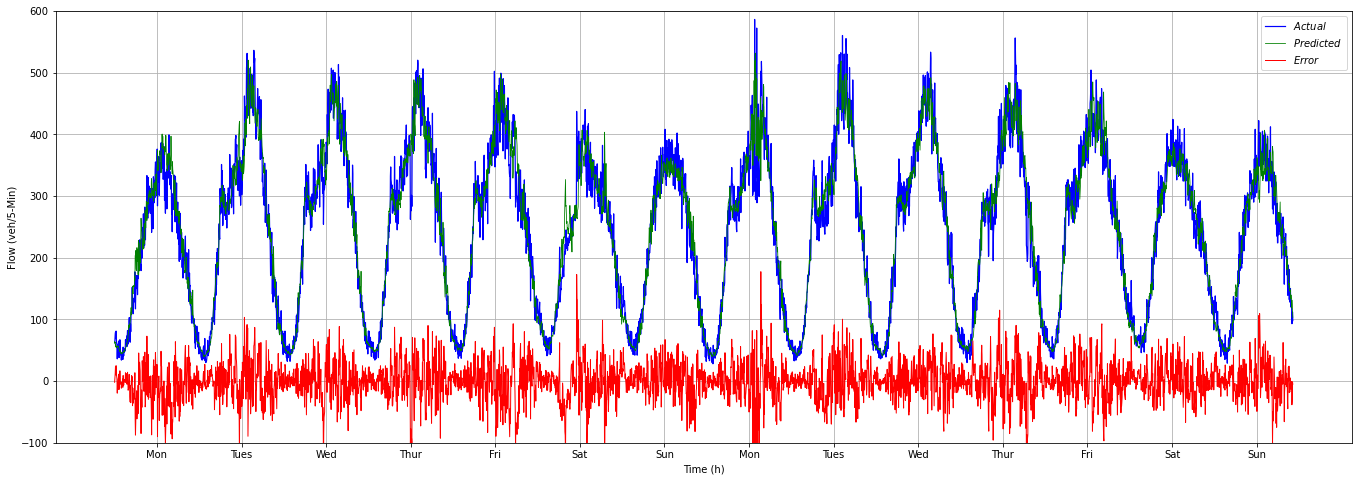

In [82]:
# Create Figure (empty canvas)
fig = plt.figure(figsize=(18,6))

# Add set of axes to figure
axes = fig.add_axes([0, 0, 1, 1]) # left, bottom, width, height (range 0 to 1)

# Plot on that set of axes
axes.plot(yv30, lw=1.2, label=r'$Actual$', color='blue')
axes.plot(test_predictions30, lw=0.8, label=r'$Predicted$', color='green')
axes.plot((yv30-test_predictions30), lw=1, label=r'$Error$', color='red')

#axes.set_xlim(0,24)
axes.set_ylim(-100,600)
axes.set_xlabel('Time (h)')
axes.set_ylabel('Flow (veh/5-Min)')

axes.legend(loc=1)
axes.grid()

axes.set_xticks([144 + i for i in range(0, 4032, 288)])
axes.set_xticklabels(['Mon', 'Tues', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun']*2)

plt.show()

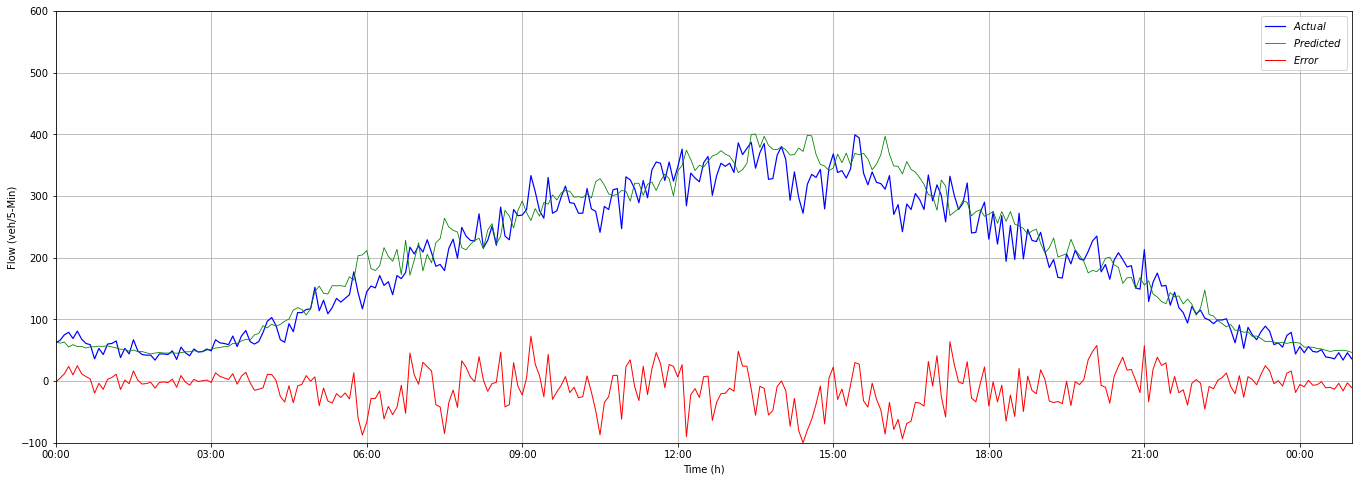

In [83]:
# Create Figure (empty canvas)
fig = plt.figure(figsize=(18,6))

# Add set of axes to figure
axes = fig.add_axes([0, 0, 1, 1]) # left, bottom, width, height (range 0 to 1)

# Plot on that set of axes
axes.plot(yv30, lw=1.2, label=r'$Actual$', color='blue')
axes.plot(test_predictions30, lw=0.8, label=r'$Predicted$', color='green')
axes.plot((yv30-test_predictions30), lw=1, label=r'$Error$', color='red')

axes.set_xlim(0,300)
axes.set_ylim(-100,600)
axes.set_xlabel('Time (h)')
axes.set_ylabel('Flow (veh/5-Min)')

axes.legend(loc=1)
axes.grid()

axes.set_xticks([0, 36, 72, 108, 144, 180, 216, 252, 288])
axes.set_xticklabels(['00:00', '03:00', '06:00', '09:00', '12:00', '15:00', '18:00', '21:00','00:00'])

plt.show()

# 60 mins ahead

In [84]:
def build_model_60(hp):
    # Inputs
    channel_Wide = keras.layers.Input(shape=Wide_train_60.shape[1:], name="WideInput")
    channel_Deep = keras.layers.Input(shape=(None, n_steps, n_features, n_channels), name="DeepInput")
    
    # Wide Model
    Wide_60 = keras.layers.Dense(
        units=hp.Int("units_NN", min_value=10, max_value=100, step=1), activation="relu"
    )(channel_Wide)
    
    # Deep Model
    # CNN 
    CNN_60 = keras.layers.TimeDistributed(
        keras.layers.Conv2D(filters=hp.Int("filters", min_value=32, max_value=512, step=32),
                            kernel_size=hp.Choice("kernel_size", [2, 3]), activation='relu'))(channel_Deep)
    flatten_60 = keras.layers.TimeDistributed(keras.layers.Flatten())(CNN_60)
    # LSTM          
    LSTM_60 = keras.layers.LSTM(units=hp.Int("units_LSTM", min_value=1, max_value=100, step=1), 
                                activation='relu')(flatten_60)
    
    # Concatenation 
    concat = keras.layers.concatenate([Wide_60, LSTM_60])
    
    # Output
    output = keras.layers.Dense(1, name= "output")(concat)
    
    # Model
    model_60 = keras.Model(inputs=[channel_Wide,channel_Deep], outputs=[output])

    # Compile
    model_60.compile(optimizer=keras.optimizers.Adam(hp.Choice("learning_rate", [1e-2, 1e-3, 1e-4])), 
        loss='mse',metrics=['MeanAbsoluteError','RootMeanSquaredError','MeanAbsolutePercentageError'])
                    
    return model_60

In [85]:
tuner60 = RandomSearch(
    build_model_60,
    objective="val_loss",
    max_trials=60,
    executions_per_trial=5,
    overwrite=False,
    directory=os.path.normpath('C:/RunsOak'),
    project_name="7d-CNN-LSTM-60",
)

INFO:tensorflow:Reloading Oracle from existing project C:\RunsOak\7d-CNN-LSTM-60\oracle.json
INFO:tensorflow:Reloading Tuner from C:\RunsOak\7d-CNN-LSTM-60\tuner0.json


In [86]:
tuner60.search_space_summary()

Search space summary
Default search space size: 5
units_NN (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 100, 'step': 1, 'sampling': None}
filters (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
kernel_size (Choice)
{'default': 2, 'conditions': [], 'values': [2, 3], 'ordered': True}
units_LSTM (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 100, 'step': 1, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [87]:
tuner60.search((Wt60,Xt60), yt60, epochs=200,
            validation_split = val_percent,
            callbacks=[early_stop],
            verbose=2)

INFO:tensorflow:Oracle triggered exit


In [88]:
tuner60.results_summary(1)

Results summary
Results in C:\RunsOak\7d-CNN-LSTM-60
Showing 1 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
units_NN: 92
filters: 192
kernel_size: 2
units_LSTM: 84
learning_rate: 0.001
Score: 0.002281335275620222


### Best model

In [89]:
best_hp60 = tuner60.get_best_hyperparameters()[0]
model60 = tuner60.hypermodel.build(best_hp60)

In [90]:
scaler_filename = "Best_HP/7d-ConvLSTM-60"
joblib.dump(best_hp60, scaler_filename) 

['Best_HP/7d-ConvLSTM-60']

In [91]:
model60.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
DeepInput (InputLayer)          [(None, None, 5, 6,  0                                            
__________________________________________________________________________________________________
time_distributed (TimeDistribut (None, None, 4, 5, 1 960         DeepInput[0][0]                  
__________________________________________________________________________________________________
WideInput (InputLayer)          [(None, 14)]         0                                            
__________________________________________________________________________________________________
time_distributed_1 (TimeDistrib (None, None, 3840)   0           time_distributed[0][0]           
_______________________________________________________________________________________

In [92]:
#model60.fit((Wt60,Xt60), yt60, 
#            epochs = 100, 
#            verbose = 0
#            )

In [93]:
#model60.save("my_dir/7d-CNN-LSTM-60")

In [94]:
#metrics60 = pd.DataFrame(model60.history.history)

In [95]:
#metrics60[['loss']].plot()

In [96]:
MSE60  = []
MAE60  = []
RMSE60 = []
MAPE60 = []

for i in range(100):
    print(f"run: {i+1}")
    model60.fit((Wt60,Xt60), yt60, 
            epochs = 200, validation_split = val_percent,
            callbacks = [stop],
            verbose = 1
            )
    
    test_predictions60 = model60.predict((Wv60,Xv60))

    yv60 = scaler.inverse_transform(Test.drop('Timestamp', axis = 1))
    yv60 = yv60[26:,3]

    df = Test.drop(Test.head(26).index)
    df.reset_index(inplace = True)
    df = df.drop(columns=['index','Timestamp'])
    df['f4'] = pd.Series(test_predictions60.flatten())

    test_predictions60 = scaler.inverse_transform(df)

    test_predictions60 = test_predictions60[:,3]
    
    MSE60.append(mean_squared_error(yv60,test_predictions60))

    MAE60.append(mean_absolute_error(yv60,test_predictions60))

    RMSE60.append(np.sqrt(mean_squared_error(yv60,test_predictions60)))

    MAPE60.append(mean_absolute_percentage_error(yv60,test_predictions60)*100)


    current_mse = mean_squared_error(yv60,test_predictions60)
    if all(i > current_mse for i in MSE60):
        model60.save("my_dir/7d-CNN-LSTM-60")

eval60 = [mean(MSE60), mean(MAE60), mean(RMSE60), mean(MAPE60)]
std60 = [stdev(MSE60), stdev(MAE60), stdev(RMSE60), stdev(MAPE60)]
print(eval60)

run: 1
Epoch 1/200
1422/1422 [==============================] - 58s 41ms/step - loss: 0.0036 - mean_absolute_error: 0.0430 - root_mean_squared_error: 0.0599 - mean_absolute_percentage_error: 678.9010 - val_loss: 0.0024 - val_mean_absolute_error: 0.0365 - val_root_mean_squared_error: 0.0495 - val_mean_absolute_percentage_error: 12.1870
Epoch 2/200
1422/1422 [==============================] - 54s 38ms/step - loss: 0.0029 - mean_absolute_error: 0.0397 - root_mean_squared_error: 0.0537 - mean_absolute_percentage_error: 1256.8441 - val_loss: 0.0026 - val_mean_absolute_error: 0.0378 - val_root_mean_squared_error: 0.0514 - val_mean_absolute_percentage_error: 12.7537
Epoch 3/200
1422/1422 [==============================] - 54s 38ms/step - loss: 0.0028 - mean_absolute_error: 0.0393 - root_mean_squared_error: 0.0532 - mean_absolute_percentage_error: 988.3091 - val_loss: 0.0025 - val_mean_absolute_error: 0.0366 - val_root_mean_squared_error: 0.0495 - val_mean_absolute_percentage_error: 11.9327
Ep

1422/1422 [==============================] - 51s 36ms/step - loss: 0.0022 - mean_absolute_error: 0.0345 - root_mean_squared_error: 0.0466 - mean_absolute_percentage_error: 816.6864 - val_loss: 0.0026 - val_mean_absolute_error: 0.0376 - val_root_mean_squared_error: 0.0510 - val_mean_absolute_percentage_error: 12.0624
Epoch 3/200
1422/1422 [==============================] - 51s 36ms/step - loss: 0.0022 - mean_absolute_error: 0.0345 - root_mean_squared_error: 0.0466 - mean_absolute_percentage_error: 939.9805 - val_loss: 0.0024 - val_mean_absolute_error: 0.0359 - val_root_mean_squared_error: 0.0488 - val_mean_absolute_percentage_error: 12.1985
Epoch 4/200
1422/1422 [==============================] - 50s 35ms/step - loss: 0.0021 - mean_absolute_error: 0.0343 - root_mean_squared_error: 0.0463 - mean_absolute_percentage_error: 1030.8740 - val_loss: 0.0025 - val_mean_absolute_error: 0.0367 - val_root_mean_squared_error: 0.0500 - val_mean_absolute_percentage_error: 11.9707
Epoch 5/200
1422/1422

Epoch 3/200
1422/1422 [==============================] - 51s 36ms/step - loss: 0.0019 - mean_absolute_error: 0.0321 - root_mean_squared_error: 0.0431 - mean_absolute_percentage_error: 395.1456 - val_loss: 0.0027 - val_mean_absolute_error: 0.0380 - val_root_mean_squared_error: 0.0519 - val_mean_absolute_percentage_error: 12.6579
Epoch 4/200
1422/1422 [==============================] - 51s 36ms/step - loss: 0.0019 - mean_absolute_error: 0.0321 - root_mean_squared_error: 0.0432 - mean_absolute_percentage_error: 174.3334 - val_loss: 0.0026 - val_mean_absolute_error: 0.0378 - val_root_mean_squared_error: 0.0511 - val_mean_absolute_percentage_error: 13.3638
Epoch 5/200
1422/1422 [==============================] - 51s 36ms/step - loss: 0.0018 - mean_absolute_error: 0.0319 - root_mean_squared_error: 0.0428 - mean_absolute_percentage_error: 623.3936 - val_loss: 0.0027 - val_mean_absolute_error: 0.0380 - val_root_mean_squared_error: 0.0520 - val_mean_absolute_percentage_error: 12.4587
Epoch 6/20

1422/1422 [==============================] - 50s 35ms/step - loss: 0.0017 - mean_absolute_error: 0.0304 - root_mean_squared_error: 0.0407 - mean_absolute_percentage_error: 374.2837 - val_loss: 0.0027 - val_mean_absolute_error: 0.0382 - val_root_mean_squared_error: 0.0519 - val_mean_absolute_percentage_error: 12.6288
Epoch 2/200
1422/1422 [==============================] - 50s 36ms/step - loss: 0.0016 - mean_absolute_error: 0.0302 - root_mean_squared_error: 0.0404 - mean_absolute_percentage_error: 137.0724 - val_loss: 0.0028 - val_mean_absolute_error: 0.0388 - val_root_mean_squared_error: 0.0531 - val_mean_absolute_percentage_error: 12.6434
Epoch 3/200
1422/1422 [==============================] - 51s 36ms/step - loss: 0.0016 - mean_absolute_error: 0.0301 - root_mean_squared_error: 0.0403 - mean_absolute_percentage_error: 75.0400 - val_loss: 0.0028 - val_mean_absolute_error: 0.0388 - val_root_mean_squared_error: 0.0531 - val_mean_absolute_percentage_error: 12.6751
Epoch 4/200
1422/1422 [

1422/1422 [==============================] - 51s 36ms/step - loss: 0.0015 - mean_absolute_error: 0.0286 - root_mean_squared_error: 0.0382 - mean_absolute_percentage_error: 341.3465 - val_loss: 0.0029 - val_mean_absolute_error: 0.0394 - val_root_mean_squared_error: 0.0536 - val_mean_absolute_percentage_error: 12.7158
Epoch 3/200
1422/1422 [==============================] - 51s 36ms/step - loss: 0.0014 - mean_absolute_error: 0.0284 - root_mean_squared_error: 0.0380 - mean_absolute_percentage_error: 520.3400 - val_loss: 0.0032 - val_mean_absolute_error: 0.0413 - val_root_mean_squared_error: 0.0565 - val_mean_absolute_percentage_error: 13.9035
Epoch 4/200
1422/1422 [==============================] - 50s 35ms/step - loss: 0.0014 - mean_absolute_error: 0.0282 - root_mean_squared_error: 0.0377 - mean_absolute_percentage_error: 249.9273 - val_loss: 0.0029 - val_mean_absolute_error: 0.0397 - val_root_mean_squared_error: 0.0540 - val_mean_absolute_percentage_error: 13.1313
Epoch 5/200
1422/1422 

1422/1422 [==============================] - 51s 36ms/step - loss: 0.0012 - mean_absolute_error: 0.0261 - root_mean_squared_error: 0.0347 - mean_absolute_percentage_error: 296.8036 - val_loss: 0.0031 - val_mean_absolute_error: 0.0409 - val_root_mean_squared_error: 0.0559 - val_mean_absolute_percentage_error: 12.9280
Epoch 3/200
1422/1422 [==============================] - 51s 36ms/step - loss: 0.0012 - mean_absolute_error: 0.0260 - root_mean_squared_error: 0.0345 - mean_absolute_percentage_error: 281.5713 - val_loss: 0.0031 - val_mean_absolute_error: 0.0409 - val_root_mean_squared_error: 0.0558 - val_mean_absolute_percentage_error: 13.0688
Epoch 4/200
1422/1422 [==============================] - 49s 35ms/step - loss: 0.0012 - mean_absolute_error: 0.0259 - root_mean_squared_error: 0.0344 - mean_absolute_percentage_error: 143.5473 - val_loss: 0.0032 - val_mean_absolute_error: 0.0412 - val_root_mean_squared_error: 0.0565 - val_mean_absolute_percentage_error: 13.0557
Epoch 5/200
1422/1422 

1422/1422 [==============================] - 49s 34ms/step - loss: 0.0010 - mean_absolute_error: 0.0239 - root_mean_squared_error: 0.0316 - mean_absolute_percentage_error: 425.0592 - val_loss: 0.0033 - val_mean_absolute_error: 0.0420 - val_root_mean_squared_error: 0.0575 - val_mean_absolute_percentage_error: 13.4622
Epoch 6/200
1422/1422 [==============================] - 50s 35ms/step - loss: 9.9636e-04 - mean_absolute_error: 0.0239 - root_mean_squared_error: 0.0316 - mean_absolute_percentage_error: 513.1259 - val_loss: 0.0032 - val_mean_absolute_error: 0.0415 - val_root_mean_squared_error: 0.0569 - val_mean_absolute_percentage_error: 13.3126
Epoch 7/200
1422/1422 [==============================] - 49s 35ms/step - loss: 9.8299e-04 - mean_absolute_error: 0.0238 - root_mean_squared_error: 0.0314 - mean_absolute_percentage_error: 263.5403 - val_loss: 0.0033 - val_mean_absolute_error: 0.0423 - val_root_mean_squared_error: 0.0579 - val_mean_absolute_percentage_error: 13.5216
Epoch 8/200
14

1422/1422 [==============================] - 49s 34ms/step - loss: 8.1733e-04 - mean_absolute_error: 0.0218 - root_mean_squared_error: 0.0286 - mean_absolute_percentage_error: 370.5605 - val_loss: 0.0035 - val_mean_absolute_error: 0.0435 - val_root_mean_squared_error: 0.0595 - val_mean_absolute_percentage_error: 13.8553
Epoch 7/200
1422/1422 [==============================] - 49s 35ms/step - loss: 8.0393e-04 - mean_absolute_error: 0.0216 - root_mean_squared_error: 0.0284 - mean_absolute_percentage_error: 49.8719 - val_loss: 0.0035 - val_mean_absolute_error: 0.0430 - val_root_mean_squared_error: 0.0589 - val_mean_absolute_percentage_error: 13.6073
run: 43
Epoch 1/200
1422/1422 [==============================] - 49s 35ms/step - loss: 8.3647e-04 - mean_absolute_error: 0.0220 - root_mean_squared_error: 0.0289 - mean_absolute_percentage_error: 500.6574 - val_loss: 0.0035 - val_mean_absolute_error: 0.0431 - val_root_mean_squared_error: 0.0593 - val_mean_absolute_percentage_error: 13.5344
Epo

1422/1422 [==============================] - 49s 34ms/step - loss: 7.2820e-04 - mean_absolute_error: 0.0206 - root_mean_squared_error: 0.0270 - mean_absolute_percentage_error: 132.2168 - val_loss: 0.0036 - val_mean_absolute_error: 0.0437 - val_root_mean_squared_error: 0.0596 - val_mean_absolute_percentage_error: 13.9873
Epoch 2/200
1422/1422 [==============================] - 49s 34ms/step - loss: 7.3167e-04 - mean_absolute_error: 0.0207 - root_mean_squared_error: 0.0270 - mean_absolute_percentage_error: 179.9865 - val_loss: 0.0036 - val_mean_absolute_error: 0.0441 - val_root_mean_squared_error: 0.0601 - val_mean_absolute_percentage_error: 13.6716
Epoch 3/200
1422/1422 [==============================] - 49s 34ms/step - loss: 7.1377e-04 - mean_absolute_error: 0.0205 - root_mean_squared_error: 0.0267 - mean_absolute_percentage_error: 74.0120 - val_loss: 0.0036 - val_mean_absolute_error: 0.0440 - val_root_mean_squared_error: 0.0603 - val_mean_absolute_percentage_error: 13.9066
Epoch 4/200

1422/1422 [==============================] - 48s 34ms/step - loss: 6.2767e-04 - mean_absolute_error: 0.0192 - root_mean_squared_error: 0.0251 - mean_absolute_percentage_error: 48.5345 - val_loss: 0.0037 - val_mean_absolute_error: 0.0447 - val_root_mean_squared_error: 0.0612 - val_mean_absolute_percentage_error: 14.2201
Epoch 6/200
1422/1422 [==============================] - 48s 34ms/step - loss: 6.2384e-04 - mean_absolute_error: 0.0191 - root_mean_squared_error: 0.0250 - mean_absolute_percentage_error: 310.4230 - val_loss: 0.0038 - val_mean_absolute_error: 0.0450 - val_root_mean_squared_error: 0.0617 - val_mean_absolute_percentage_error: 14.1982
Epoch 7/200
1422/1422 [==============================] - 48s 34ms/step - loss: 6.1828e-04 - mean_absolute_error: 0.0190 - root_mean_squared_error: 0.0249 - mean_absolute_percentage_error: 486.3997 - val_loss: 0.0038 - val_mean_absolute_error: 0.0448 - val_root_mean_squared_error: 0.0617 - val_mean_absolute_percentage_error: 13.8062
Epoch 8/200

1422/1422 [==============================] - 46s 33ms/step - loss: 5.3233e-04 - mean_absolute_error: 0.0178 - root_mean_squared_error: 0.0231 - mean_absolute_percentage_error: 330.9806 - val_loss: 0.0039 - val_mean_absolute_error: 0.0454 - val_root_mean_squared_error: 0.0624 - val_mean_absolute_percentage_error: 14.034176 - root_mean_squared_e - ETA: 1s - loss: 5.3218e-04 - mean_absolute_error: 0.0178 - root_mean_squared_er
Epoch 8/200
1422/1422 [==============================] - 46s 32ms/step - loss: 5.3135e-04 - mean_absolute_error: 0.0177 - root_mean_squared_error: 0.0231 - mean_absolute_percentage_error: 103.1663 - val_loss: 0.0040 - val_mean_absolute_error: 0.0460 - val_root_mean_squared_error: 0.0631 - val_mean_absolute_percentage_error: 14.3664
run: 61
Epoch 1/200
1422/1422 [==============================] - 46s 32ms/step - loss: 5.4691e-04 - mean_absolute_error: 0.0179 - root_mean_squared_error: 0.0234 - mean_absolute_percentage_error: 91.7913 - val_loss: 0.0039 - val_mean_abso

1422/1422 [==============================] - 47s 33ms/step - loss: 4.7505e-04 - mean_absolute_error: 0.0168 - root_mean_squared_error: 0.0218 - mean_absolute_percentage_error: 263.4153 - val_loss: 0.0041 - val_mean_absolute_error: 0.0467 - val_root_mean_squared_error: 0.0644 - val_mean_absolute_percentage_error: 14.6438
Epoch 2/200
1422/1422 [==============================] - 47s 33ms/step - loss: 4.6999e-04 - mean_absolute_error: 0.0167 - root_mean_squared_error: 0.0217 - mean_absolute_percentage_error: 137.3678 - val_loss: 0.0042 - val_mean_absolute_error: 0.0472 - val_root_mean_squared_error: 0.0651 - val_mean_absolute_percentage_error: 14.6997
Epoch 3/200
1422/1422 [==============================] - 47s 33ms/step - loss: 4.6452e-04 - mean_absolute_error: 0.0166 - root_mean_squared_error: 0.0216 - mean_absolute_percentage_error: 57.7545 - val_loss: 0.0042 - val_mean_absolute_error: 0.0472 - val_root_mean_squared_error: 0.0652 - val_mean_absolute_percentage_error: 14.7060
Epoch 4/200

1422/1422 [==============================] - 46s 32ms/step - loss: 4.0298e-04 - mean_absolute_error: 0.0155 - root_mean_squared_error: 0.0201 - mean_absolute_percentage_error: 145.0556 - val_loss: 0.0042 - val_mean_absolute_error: 0.0473 - val_root_mean_squared_error: 0.0651 - val_mean_absolute_percentage_error: 14.5924
run: 71
Epoch 1/200
1422/1422 [==============================] - 46s 32ms/step - loss: 4.0950e-04 - mean_absolute_error: 0.0156 - root_mean_squared_error: 0.0202 - mean_absolute_percentage_error: 511.9124 - val_loss: 0.0042 - val_mean_absolute_error: 0.0471 - val_root_mean_squared_error: 0.0649 - val_mean_absolute_percentage_error: 14.6099
Epoch 2/200
1422/1422 [==============================] - 45s 31ms/step - loss: 4.0369e-04 - mean_absolute_error: 0.0155 - root_mean_squared_error: 0.0201 - mean_absolute_percentage_error: 20.0513 - val_loss: 0.0042 - val_mean_absolute_error: 0.0472 - val_root_mean_squared_error: 0.0651 - val_mean_absolute_percentage_error: 14.8582
Epo

1422/1422 [==============================] - 28s 20ms/step - loss: 3.5551e-04 - mean_absolute_error: 0.0146 - root_mean_squared_error: 0.0189 - mean_absolute_percentage_error: 233.2134 - val_loss: 0.0044 - val_mean_absolute_error: 0.0478 - val_root_mean_squared_error: 0.0660 - val_mean_absolute_percentage_error: 14.8296
Epoch 6/200
1422/1422 [==============================] - 28s 20ms/step - loss: 3.4913e-04 - mean_absolute_error: 0.0144 - root_mean_squared_error: 0.0187 - mean_absolute_percentage_error: 67.2640 - val_loss: 0.0045 - val_mean_absolute_error: 0.0483 - val_root_mean_squared_error: 0.0668 - val_mean_absolute_percentage_error: 14.8799
Epoch 7/200
1422/1422 [==============================] - 28s 20ms/step - loss: 3.5171e-04 - mean_absolute_error: 0.0145 - root_mean_squared_error: 0.0188 - mean_absolute_percentage_error: 246.7284 - val_loss: 0.0044 - val_mean_absolute_error: 0.0481 - val_root_mean_squared_error: 0.0663 - val_mean_absolute_percentage_error: 14.8569
Epoch 8/200

1422/1422 [==============================] - 28s 20ms/step - loss: 3.2932e-04 - mean_absolute_error: 0.0140 - root_mean_squared_error: 0.0181 - mean_absolute_percentage_error: 79.6673 - val_loss: 0.0044 - val_mean_absolute_error: 0.0482 - val_root_mean_squared_error: 0.0665 - val_mean_absolute_percentage_error: 14.9746
Epoch 8/200
1422/1422 [==============================] - 28s 20ms/step - loss: 3.2161e-04 - mean_absolute_error: 0.0138 - root_mean_squared_error: 0.0179 - mean_absolute_percentage_error: 146.9501 - val_loss: 0.0045 - val_mean_absolute_error: 0.0488 - val_root_mean_squared_error: 0.0674 - val_mean_absolute_percentage_error: 14.7248
Epoch 9/200
1422/1422 [==============================] - 28s 20ms/step - loss: 3.2741e-04 - mean_absolute_error: 0.0140 - root_mean_squared_error: 0.0181 - mean_absolute_percentage_error: 85.7642 - val_loss: 0.0045 - val_mean_absolute_error: 0.0486 - val_root_mean_squared_error: 0.0670 - val_mean_absolute_percentage_error: 14.9439
Epoch 10/200

1422/1422 [==============================] - 28s 20ms/step - loss: 3.0442e-04 - mean_absolute_error: 0.0135 - root_mean_squared_error: 0.0174 - mean_absolute_percentage_error: 38.1715 - val_loss: 0.0045 - val_mean_absolute_error: 0.0488 - val_root_mean_squared_error: 0.0674 - val_mean_absolute_percentage_error: 14.9721
Epoch 10/200
1422/1422 [==============================] - 28s 20ms/step - loss: 2.9890e-04 - mean_absolute_error: 0.0133 - root_mean_squared_error: 0.0173 - mean_absolute_percentage_error: 51.4952 - val_loss: 0.0045 - val_mean_absolute_error: 0.0482 - val_root_mean_squared_error: 0.0667 - val_mean_absolute_percentage_error: 15.0229
Epoch 11/200
1422/1422 [==============================] - 28s 20ms/step - loss: 2.9443e-04 - mean_absolute_error: 0.0133 - root_mean_squared_error: 0.0172 - mean_absolute_percentage_error: 300.1752 - val_loss: 0.0045 - val_mean_absolute_error: 0.0488 - val_root_mean_squared_error: 0.0672 - val_mean_absolute_percentage_error: 15.1042
Epoch 12/2

1422/1422 [==============================] - 28s 20ms/step - loss: 2.6689e-04 - mean_absolute_error: 0.0126 - root_mean_squared_error: 0.0163 - mean_absolute_percentage_error: 616.5050 - val_loss: 0.0046 - val_mean_absolute_error: 0.0492 - val_root_mean_squared_error: 0.0680 - val_mean_absolute_percentage_error: 15.4691
run: 92
Epoch 1/200
1422/1422 [==============================] - 28s 20ms/step - loss: 2.7719e-04 - mean_absolute_error: 0.0129 - root_mean_squared_error: 0.0166 - mean_absolute_percentage_error: 55.7084 - val_loss: 0.0045 - val_mean_absolute_error: 0.0488 - val_root_mean_squared_error: 0.0674 - val_mean_absolute_percentage_error: 14.7585
Epoch 2/200
1422/1422 [==============================] - 28s 20ms/step - loss: 2.7967e-04 - mean_absolute_error: 0.0129 - root_mean_squared_error: 0.0167 - mean_absolute_percentage_error: 148.9901 - val_loss: 0.0046 - val_mean_absolute_error: 0.0493 - val_root_mean_squared_error: 0.0681 - val_mean_absolute_percentage_error: 15.1616
Epo

1422/1422 [==============================] - 28s 20ms/step - loss: 2.5397e-04 - mean_absolute_error: 0.0123 - root_mean_squared_error: 0.0159 - mean_absolute_percentage_error: 328.1772 - val_loss: 0.0046 - val_mean_absolute_error: 0.0489 - val_root_mean_squared_error: 0.0677 - val_mean_absolute_percentage_error: 14.9494
Epoch 9/200
1422/1422 [==============================] - 28s 20ms/step - loss: 2.5397e-04 - mean_absolute_error: 0.0123 - root_mean_squared_error: 0.0159 - mean_absolute_percentage_error: 339.4094 - val_loss: 0.0046 - val_mean_absolute_error: 0.0492 - val_root_mean_squared_error: 0.0681 - val_mean_absolute_percentage_error: 15.2435
Epoch 10/200
1422/1422 [==============================] - 28s 20ms/step - loss: 2.5637e-04 - mean_absolute_error: 0.0123 - root_mean_squared_error: 0.0160 - mean_absolute_percentage_error: 156.1460 - val_loss: 0.0046 - val_mean_absolute_error: 0.0492 - val_root_mean_squared_error: 0.0677 - val_mean_absolute_percentage_error: 15.3772
Epoch 11/

In [97]:
model60 = keras.models.load_model("my_dir/7d-CNN-LSTM-60")

In [134]:
runs = {'MSE': MSE60, 'MAE': MAE60, 'RMSE': RMSE60, 'MAPE': MAPE60}
table60 = pd.DataFrame(data=runs)
table60.to_csv("Results/Runs/7d-CNN-LSTM-60")

In [135]:
pd.read_csv("Results/Runs/7d-CNN-LSTM-60", index_col=0)

,MSE,MAE,RMSE,MAPE
0,1069.667862,23.525178,32.705777,11.250921
1,1038.128676,23.393640,32.220004,11.276079
2,1098.670403,23.885379,33.146197,11.674596
3,1046.090130,23.459184,32.343317,11.292853
4,1055.037623,23.685392,32.481343,11.484422
...,...,...,...,...
95,2027.086565,31.795675,45.023178,14.364232
96,2020.024179,31.916628,44.944679,14.498182
97,2015.217440,31.785294,44.891173,14.340295
98,2059.673471,32.073912,45.383626,14.459829


### Evaluation on inverse_transform

In [98]:
test_predictions60 = model60.predict((Wv60,Xv60))

yv60 = scaler.inverse_transform(Test.drop('Timestamp', axis = 1))
yv60 = yv60[26:,3]

df = Test.drop(Test.head(26).index)
df.reset_index(inplace = True)
df = df.drop(columns=['index','Timestamp'])
df['f4'] = pd.Series(test_predictions60.flatten())

test_predictions60 = scaler.inverse_transform(df)

test_predictions60 = test_predictions60[:,3]

#MSE60 = mean_squared_error(yv60,test_predictions60)

#MAE60 = mean_absolute_error(yv60,test_predictions60)

#RMSE60 = np.sqrt(MSE60)

#MAPE60 = mean_absolute_percentage_error(yv60,test_predictions60)*100

#eval60 = [MSE60, MAE60, RMSE60, MAPE60]
#print(eval60)

In [99]:
RA10 = ra.RA_10(np.asarray(yv60), np.asarray(test_predictions60))
RA15 = ra.RA_15(np.asarray(yv60), np.asarray(test_predictions60))
RA20 = ra.RA_20(np.asarray(yv60), np.asarray(test_predictions60))

res60 = [RA10, RA15, RA20]
print(res60)

[49.57563654518223, 66.74987518721917, 79.13130304543185]


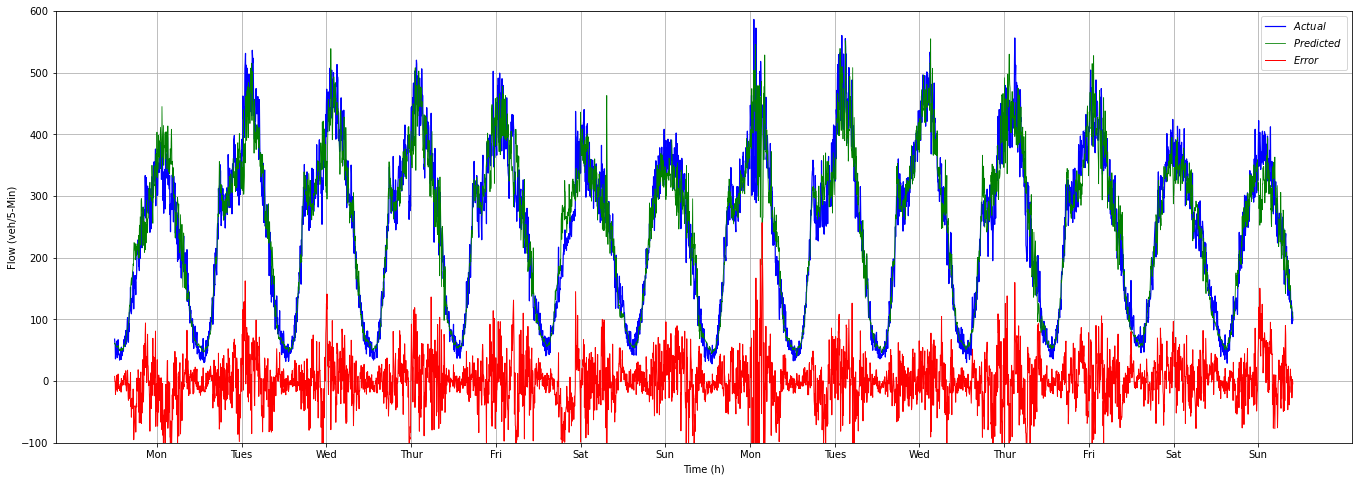

In [100]:
# Create Figure (empty canvas)
fig = plt.figure(figsize=(18,6))

# Add set of axes to figure
axes = fig.add_axes([0, 0, 1, 1]) # left, bottom, width, height (range 0 to 1)

# Plot on that set of axes
axes.plot(yv60, lw=1.2, label=r'$Actual$', color='blue')
axes.plot(test_predictions60, lw=0.8, label=r'$Predicted$', color='green')
axes.plot((yv60-test_predictions60), lw=1, label=r'$Error$', color='red')

#axes.set_xlim(0,24)
axes.set_ylim(-100,600)
axes.set_xlabel('Time (h)')
axes.set_ylabel('Flow (veh/5-Min)')

axes.legend(loc=1)
axes.grid()

axes.set_xticks([144 + i for i in range(0, 4032, 288)])
axes.set_xticklabels(['Mon', 'Tues', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun']*2)

plt.show()

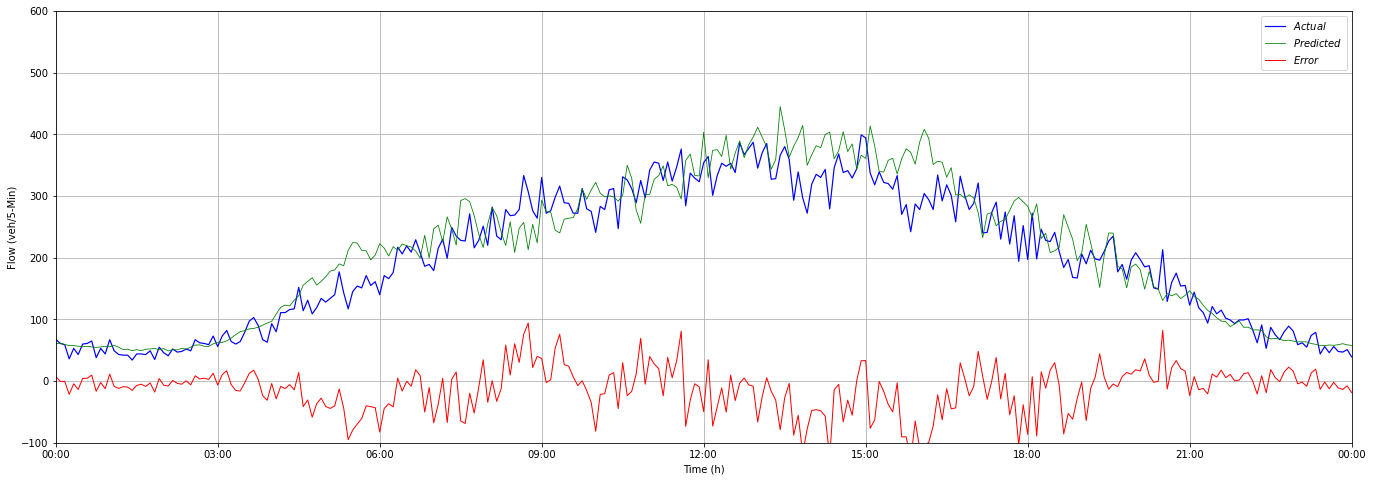

In [101]:
# Create Figure (empty canvas)
fig = plt.figure(figsize=(18,6))

# Add set of axes to figure
axes = fig.add_axes([0, 0, 1, 1]) # left, bottom, width, height (range 0 to 1)

# Plot on that set of axes
axes.plot(yv60, lw=1.2, label=r'$Actual$', color='blue')
axes.plot(test_predictions60, lw=0.8, label=r'$Predicted$', color='green')
axes.plot((yv60-test_predictions60), lw=1, label=r'$Error$', color='red')

axes.set_xlim(0,24)
axes.set_ylim(-100,600)
axes.set_xlabel('Time (h)')
axes.set_ylabel('Flow (veh/5-Min)')

axes.legend(loc=1)
axes.grid()

axes.set_xticks([0, 36, 72, 108, 144, 180, 216, 252, 288])
axes.set_xticklabels(['00:00', '03:00', '06:00', '09:00', '12:00', '15:00', '18:00', '21:00','00:00'])

plt.show()

# RESULTS

## General results

In [102]:
l = ['MSE','MAE','RMSE','MAPE','Horizon']

In [103]:
eval5.append(5)
eval15.append(15)
eval30.append(30)
eval60.append(60)

In [104]:
df = pd.DataFrame(np.array([eval5,eval15,eval30,eval60]),columns=l)
df.set_index('Horizon')

,MSE,MAE,RMSE,MAPE
Horizon,,,,
5.0,717.167084,19.823645,26.777915,9.845066
15.0,1205.972604,24.755706,34.560220,11.890542
30.0,1194.556302,25.298272,34.465564,12.157466
60.0,1578.166360,28.303964,39.489593,13.085207


## Relative accuracy

In [105]:
m = ['10%','15%','20%','Horizon']

In [106]:
res5.append(5)
res15.append(15)
res30.append(30)
res60.append(60)

In [107]:
df1 = pd.DataFrame(np.array([res5,res15,res30,res60]),columns=m)
df1.set_index('Horizon')

,10%,15%,20%
Horizon,,,
5.0,62.733383,79.711227,88.573562
15.0,56.612702,75.043587,85.952677
30.0,54.835494,73.678963,84.371884
60.0,49.575637,66.749875,79.131303


## Save

In [123]:
x = np.array([eval5, eval15, eval30, eval60])
y = np.array([std5, std15, std30, std60])

In [124]:
np.savez("Results/7b", x=x , y=y)